# Imports

In [270]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import shap
import seaborn as sns
shap.initjs()


In [271]:
import numpy as np
import pandas as pd
from sklearn.metrics import explained_variance_score

pd.options.display.float_format = '{:.4f}'.format

def drop_high_correlation(X, threshold=0.95):
    # drop highly correlated features

    corr_matrix = pd.DataFrame(X).corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

    # So we are selecting the columns which are having absolute correlation greater than 0.95 and making a list of those columns named 'dropping_these_features'.
    dropping_these_features = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    X = X.drop(columns=dropping_these_features)

    return X

def drop_x_riskiest_features(df, number_to_drop=10, rolling_window=10, target_column=''):
    correlations = pd.DataFrame()
    columns = df.columns
    
    for column in columns:
        correlations[column] = df[target_column].rolling(rolling_window).corr(df[column])
    to_drop = correlations.std().sort_values(ascending=False).head(number_to_drop).keys()
    
    df.drop(columns=to_drop, inplace=True)
    return df

def get_vol(prices, span=10, delta=pd.Timedelta(days=1)):

    Delta = delta
    # 1. compute returns of the form p[t]/p[t-1] - 1
    # 1.1 find the timestamps of p[t-1] values
    df0 = prices.index.searchsorted(prices.index - delta)
    df0 = df0[df0 > 0]

    # 1.2 align timestamps of p[t-1] to timestamps of p[t]
    df0 = pd.Series(prices.index[df0-1],    
           index=prices.index[prices.shape[0]-df0.shape[0] : ])

    # 1.3 get values by timestamps, then compute returns
    df0 = prices.loc[df0.index] / prices.loc[df0.values].values - 1

    # 2. estimate rolling standard deviation
    df0 = df0.ewm(span=span).std()

    return df0

def get_barriers(daily_volatility, prices, t_final = 5, upper_lower_multipliers = [1.5, 1.5]):

    #create a container
    barriers = pd.DataFrame(columns=['datapoints_passed', 
            'price', 'vert_barrier', \
            'top_barrier', 'bottom_barrier'], \
              index = daily_volatility.index)

    for datapoint, vol in daily_volatility.iteritems():

        datapoints_passed = len(daily_volatility.loc \
                      [daily_volatility.index[0] : datapoint])

        #set the vertical barrier 
        if (datapoints_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                datapoints_passed + t_final]
        else:
            vert_barrier = np.nan

        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[datapoint] + prices.loc[datapoint] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)

        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[datapoint] - prices.loc[datapoint] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)

        barriers.loc[datapoint, ['datapoints_passed', 'price', 'vert_barrier','top_barrier', 'bottom_barrier']] = \
        datapoints_passed, prices.loc[datapoint], vert_barrier, top_barrier, bottom_barrier

    return barriers

def get_labels(barriers):
    barriers["label_barrier"] = None
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):

            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]

            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]

            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= \
              top_barrier).any()
            condition_sl = (barriers.price[start: end] <= \
              bottom_barrier).any()

            #assign the labels
            if condition_pt: 
                barriers['label_barrier'][i] = 1 # Top
            elif condition_sl: 
                barriers['label_barrier'][i] = 0 # Bottom  
            else: 
                barriers['label_barrier'][i] = 0.5 # time barrier

    return barriers


def SFI(featNames, split_model, training_data, train_split_index, test_split_index): 
    imp=pd.DataFrame(columns=['score'])
    for featName in featNames:
        split_model.fit(training_data.loc[train_split_index, featName].values.reshape(-1,1),
                    training_data.loc[train_split_index,
                                        ['target']].values.reshape(-1,1))
        y_pred = split_model.predict(training_data.loc[test_split_index, featName].values.reshape(-1,1))
        imp.loc[featName,'score']= explained_variance_score(training_data.loc[test_split_index, 'target'].values.reshape(-1,1), y_pred)
    return imp

In [272]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Data loading

In [273]:
#ML_FILE = "ml_trades_2024-07-24_10-48-33"
ML_FILE = "trades_detailed_XAUUSD_fee_0_0"


In [274]:
df = pd.read_csv(f"data/overnight_mom/results/{ML_FILE}.csv")
xauusd = pd.read_csv("data/overnight_mom/XAUUSD/combined_data.csv")


In [275]:
df = df[df['session'] == "london"]

In [276]:
df

,asset,entry_time,exit_time,entry_price,exit_price,direction,session,attempt,status,position_size,risk_amount,pnl,return_pct,holding_time,ref_close,date,day_of_week,duration_minutes
1,XAUUSD,2020-01-02 08:00:00+00:00,2020-01-02 13:51:00+00:00,1518.9750,1526.5699,long,london,1,tp_hit,131.6677,1000.0000,1000.0000,0.0100,0 days 05:51:00,1516.9150,2020-01-02,Thursday,351.0000
4,XAUUSD,2020-01-03 08:00:00+00:00,2020-01-03 16:00:00+00:00,1545.0380,1549.0080,long,london,1,session_close,130.7411,1010.0000,519.0423,0.0051,0 days 08:00:00,1529.1080,2020-01-03,Friday,480.0000
7,XAUUSD,2020-01-06 08:00:00+00:00,2020-01-06 15:36:00+00:00,1572.2550,1564.3937,long,london,1,sl_hit,129.1381,1015.1904,-1015.1904,-0.0100,0 days 07:36:00,1551.5150,2020-01-06,Monday,456.0000
10,XAUUSD,2020-01-06 15:36:00+00:00,2020-01-06 16:00:00+00:00,1564.3937,1563.9580,long,london,2,session_close,128.4892,1005.0385,-55.9860,-0.0006,0 days 00:24:00,1551.5150,2020-01-06,Monday,24.0000
12,XAUUSD,2020-01-07 08:00:00+00:00,2020-01-07 16:00:00+00:00,1569.4480,1568.4980,long,london,1,session_close,128.0041,1004.4787,-121.6039,-0.0012,0 days 08:00:00,1564.1650,2020-01-07,Tuesday,480.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,XAUUSD,2024-11-20 08:00:00+00:00,2024-11-20 13:07:00+00:00,2621.1150,2634.2206,short,london,1,sl_hit,142.4575,1866.9868,-1866.9868,-0.0100,0 days 05:07:00,2624.3150,2024-11-20,Wednesday,307.0000
5211,XAUUSD,2024-11-20 13:07:00+00:00,2024-11-20 15:15:00+00:00,2634.2206,2647.3917,short,london,2,sl_hit,140.3312,1848.3169,-1848.3169,-0.0100,0 days 02:08:00,2624.3150,2024-11-20,Wednesday,128.0000
5213,XAUUSD,2024-11-20 15:15:00+00:00,2024-11-20 16:00:00+00:00,2647.3917,2647.9350,short,london,3,session_close,138.2367,1829.8338,-75.1071,-0.0004,0 days 00:45:00,2624.3150,2024-11-20,Wednesday,45.0000
5215,XAUUSD,2024-11-21 08:00:00+00:00,2024-11-21 16:00:00+00:00,2663.7150,2667.3550,long,london,1,session_close,137.3332,1829.0827,499.8929,0.0027,0 days 08:00:00,2648.7080,2024-11-21,Thursday,480.0000


In [277]:
xauusd = xauusd[['timestamp', 'close', 'open', 'high', 'low', 'volume']]

<Axes: >

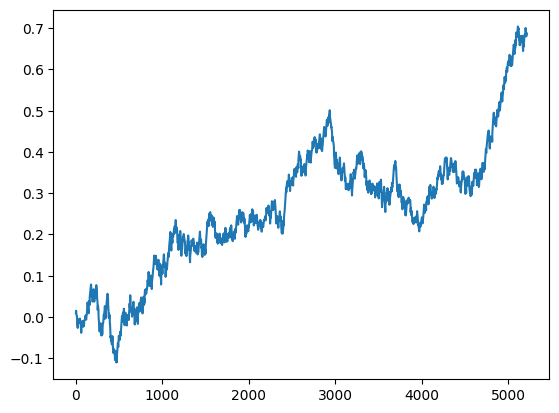

In [278]:
df.return_pct.cumsum().plot()

In [279]:
# Genereate features

xauusd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2576160 entries, 0 to 2576159
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  object 
 1   close      float64
 2   open       float64
 3   high       float64
 4   low        float64
 5   volume     float64
dtypes: float64(5), object(1)
memory usage: 117.9+ MB


In [280]:
import pandas as pd
import numpy as np

# Convert timestamps to datetime
xauusd['timestamp'] = pd.to_datetime(xauusd['timestamp'])
df['entry_time'] = pd.to_datetime(df['entry_time'])

# Create date and day-of-week features
xauusd['date'] = xauusd['timestamp'].dt.date
xauusd['day_of_week'] = xauusd['timestamp'].dt.dayofweek

# Compute minute returns for intraday volatility
xauusd['return'] = xauusd['close'].pct_change()

# Aggregate minute data into daily features
daily_features = xauusd.groupby('date').agg(
    daily_open=('open', 'first'),
    daily_close=('close', 'last'),
    daily_high=('high', 'max'),
    daily_low=('low', 'min'),
    daily_volatility=('return', 'std'),
    daily_avg_return=('return', 'mean'),
    daily_volume=('volume', 'sum'),
    day_of_week=('day_of_week', 'first')
).reset_index()

daily_features['intraday_range'] = daily_features['daily_high'] - daily_features['daily_low']
daily_features['daily_return'] = daily_features['daily_close'] / daily_features['daily_open'] - 1

# Feature: gap magnitude and normalized gap (signal strength vs noise)
daily_features['daily_gap'] = daily_features['daily_open'] - daily_features['daily_close']
daily_features['norm_gap'] = daily_features.apply(
    lambda row: row['daily_gap'] / row['intraday_range'] if row['intraday_range'] != 0 else 0, axis=1
)

# Rolling features to capture multi-day regime (e.g., 5-day window)
window = 5
daily_features = daily_features.sort_values('date')
daily_features['roll_volatility'] = daily_features['daily_volatility'].rolling(window).mean()
daily_features['roll_norm_gap'] = daily_features['norm_gap'].rolling(window).mean()

# For the overnight momentum strategy, use the prior day's features
df['trade_date'] = (df['entry_time'] - pd.Timedelta(days=1)).dt.date

# Merge daily features with the trades dataframe.
# Use errors='ignore' in drop to avoid KeyError if 'date' is not present.
df_features = df.merge(daily_features, left_on='trade_date', right_on='date', how='left')
df_features = df_features.drop(columns=['date'], errors='ignore')


In [281]:
df_features

,asset,entry_time,exit_time,entry_price,exit_price,direction,session,attempt,status,position_size,risk_amount,pnl,return_pct,holding_time,ref_close,date_x,day_of_week_x,duration_minutes,trade_date,date_y,daily_open,daily_close,daily_high,daily_low,daily_volatility,daily_avg_return,daily_volume,day_of_week_y,intraday_range,daily_return,daily_gap,norm_gap,roll_volatility,roll_norm_gap
0,XAUUSD,2020-01-02 08:00:00+00:00,2020-01-02 13:51:00+00:00,1518.9750,1526.5699,long,london,1,tp_hit,131.6677,1000.0000,1000.0000,0.0100,0 days 05:51:00,1516.9150,2020-01-02,Thursday,351.0000,2020-01-01,2020-01-01,1516.9150,1518.2850,1521.0680,1516.9150,0.0001,0.0000,0.5852,2,4.1530,0.0009,-1.3700,-0.3299,NaN,NaN
1,XAUUSD,2020-01-03 08:00:00+00:00,2020-01-03 16:00:00+00:00,1545.0380,1549.0080,long,london,1,session_close,130.7411,1010.0000,519.0423,0.0051,0 days 08:00:00,1529.1080,2020-01-03,Friday,480.0000,2020-01-02,2020-01-02,1518.3050,1528.7280,1531.3280,1517.1150,0.0001,0.0000,44.2930,3,14.2130,0.0069,-10.4230,-0.7333,NaN,NaN
2,XAUUSD,2020-01-06 08:00:00+00:00,2020-01-06 15:36:00+00:00,1572.2550,1564.3937,long,london,1,sl_hit,129.1381,1015.1904,-1015.1904,-0.0100,0 days 07:36:00,1551.5150,2020-01-06,Monday,456.0000,2020-01-05,2020-01-05,1551.5150,1569.1450,1585.6250,1551.5150,0.0004,0.0000,3.6564,6,34.1100,0.0114,-17.6300,-0.5169,0.0002,-0.4999
3,XAUUSD,2020-01-06 15:36:00+00:00,2020-01-06 16:00:00+00:00,1564.3937,1563.9580,long,london,2,session_close,128.4892,1005.0385,-55.9860,-0.0006,0 days 00:24:00,1551.5150,2020-01-06,Monday,24.0000,2020-01-05,2020-01-05,1551.5150,1569.1450,1585.6250,1551.5150,0.0004,0.0000,3.6564,6,34.1100,0.0114,-17.6300,-0.5169,0.0002,-0.4999
4,XAUUSD,2020-01-07 08:00:00+00:00,2020-01-07 16:00:00+00:00,1569.4480,1568.4980,long,london,1,session_close,128.0041,1004.4787,-121.6039,-0.0012,0 days 08:00:00,1564.1650,2020-01-07,Tuesday,480.0000,2020-01-06,2020-01-06,1569.1450,1563.6780,1579.9650,1560.7550,0.0002,-0.0000,70.6369,0,19.2100,-0.0035,5.4670,0.2846,0.0002,-0.3770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,XAUUSD,2024-11-20 08:00:00+00:00,2024-11-20 13:07:00+00:00,2621.1150,2634.2206,short,london,1,sl_hit,142.4575,1866.9868,-1866.9868,-0.0100,0 days 05:07:00,2624.3150,2024-11-20,Wednesday,307.0000,2024-11-19,2024-11-19,2612.4950,2635.0150,2639.3250,2610.9050,0.0002,0.0000,76628230.1153,1,28.4200,0.0086,-22.5200,-0.7924,0.0002,-0.4386
1856,XAUUSD,2024-11-20 13:07:00+00:00,2024-11-20 15:15:00+00:00,2634.2206,2647.3917,short,london,2,sl_hit,140.3312,1848.3169,-1848.3169,-0.0100,0 days 02:08:00,2624.3150,2024-11-20,Wednesday,128.0000,2024-11-19,2024-11-19,2612.4950,2635.0150,2639.3250,2610.9050,0.0002,0.0000,76628230.1153,1,28.4200,0.0086,-22.5200,-0.7924,0.0002,-0.4386
1857,XAUUSD,2024-11-20 15:15:00+00:00,2024-11-20 16:00:00+00:00,2647.3917,2647.9350,short,london,3,session_close,138.2367,1829.8338,-75.1071,-0.0004,0 days 00:45:00,2624.3150,2024-11-20,Wednesday,45.0000,2024-11-19,2024-11-19,2612.4950,2635.0150,2639.3250,2610.9050,0.0002,0.0000,76628230.1153,1,28.4200,0.0086,-22.5200,-0.7924,0.0002,-0.4386
1858,XAUUSD,2024-11-21 08:00:00+00:00,2024-11-21 16:00:00+00:00,2663.7150,2667.3550,long,london,1,session_close,137.3332,1829.0827,499.8929,0.0027,0 days 08:00:00,2648.7080,2024-11-21,Thursday,480.0000,2024-11-20,2024-11-20,2635.0150,2652.0250,2655.2750,2618.7050,0.0002,0.0000,66273509.8787,2,36.5700,0.0065,-17.0100,-0.4651,0.0001,-0.5690


In [282]:
raw = df_features.copy()

In [283]:
df_features = df_features.sort_values(by='entry_time')

In [284]:
df_features

,asset,entry_time,exit_time,entry_price,exit_price,direction,session,attempt,status,position_size,risk_amount,pnl,return_pct,holding_time,ref_close,date_x,day_of_week_x,duration_minutes,trade_date,date_y,daily_open,daily_close,daily_high,daily_low,daily_volatility,daily_avg_return,daily_volume,day_of_week_y,intraday_range,daily_return,daily_gap,norm_gap,roll_volatility,roll_norm_gap
0,XAUUSD,2020-01-02 08:00:00+00:00,2020-01-02 13:51:00+00:00,1518.9750,1526.5699,long,london,1,tp_hit,131.6677,1000.0000,1000.0000,0.0100,0 days 05:51:00,1516.9150,2020-01-02,Thursday,351.0000,2020-01-01,2020-01-01,1516.9150,1518.2850,1521.0680,1516.9150,0.0001,0.0000,0.5852,2,4.1530,0.0009,-1.3700,-0.3299,NaN,NaN
1,XAUUSD,2020-01-03 08:00:00+00:00,2020-01-03 16:00:00+00:00,1545.0380,1549.0080,long,london,1,session_close,130.7411,1010.0000,519.0423,0.0051,0 days 08:00:00,1529.1080,2020-01-03,Friday,480.0000,2020-01-02,2020-01-02,1518.3050,1528.7280,1531.3280,1517.1150,0.0001,0.0000,44.2930,3,14.2130,0.0069,-10.4230,-0.7333,NaN,NaN
2,XAUUSD,2020-01-06 08:00:00+00:00,2020-01-06 15:36:00+00:00,1572.2550,1564.3937,long,london,1,sl_hit,129.1381,1015.1904,-1015.1904,-0.0100,0 days 07:36:00,1551.5150,2020-01-06,Monday,456.0000,2020-01-05,2020-01-05,1551.5150,1569.1450,1585.6250,1551.5150,0.0004,0.0000,3.6564,6,34.1100,0.0114,-17.6300,-0.5169,0.0002,-0.4999
3,XAUUSD,2020-01-06 15:36:00+00:00,2020-01-06 16:00:00+00:00,1564.3937,1563.9580,long,london,2,session_close,128.4892,1005.0385,-55.9860,-0.0006,0 days 00:24:00,1551.5150,2020-01-06,Monday,24.0000,2020-01-05,2020-01-05,1551.5150,1569.1450,1585.6250,1551.5150,0.0004,0.0000,3.6564,6,34.1100,0.0114,-17.6300,-0.5169,0.0002,-0.4999
4,XAUUSD,2020-01-07 08:00:00+00:00,2020-01-07 16:00:00+00:00,1569.4480,1568.4980,long,london,1,session_close,128.0041,1004.4787,-121.6039,-0.0012,0 days 08:00:00,1564.1650,2020-01-07,Tuesday,480.0000,2020-01-06,2020-01-06,1569.1450,1563.6780,1579.9650,1560.7550,0.0002,-0.0000,70.6369,0,19.2100,-0.0035,5.4670,0.2846,0.0002,-0.3770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,XAUUSD,2024-11-20 08:00:00+00:00,2024-11-20 13:07:00+00:00,2621.1150,2634.2206,short,london,1,sl_hit,142.4575,1866.9868,-1866.9868,-0.0100,0 days 05:07:00,2624.3150,2024-11-20,Wednesday,307.0000,2024-11-19,2024-11-19,2612.4950,2635.0150,2639.3250,2610.9050,0.0002,0.0000,76628230.1153,1,28.4200,0.0086,-22.5200,-0.7924,0.0002,-0.4386
1856,XAUUSD,2024-11-20 13:07:00+00:00,2024-11-20 15:15:00+00:00,2634.2206,2647.3917,short,london,2,sl_hit,140.3312,1848.3169,-1848.3169,-0.0100,0 days 02:08:00,2624.3150,2024-11-20,Wednesday,128.0000,2024-11-19,2024-11-19,2612.4950,2635.0150,2639.3250,2610.9050,0.0002,0.0000,76628230.1153,1,28.4200,0.0086,-22.5200,-0.7924,0.0002,-0.4386
1857,XAUUSD,2024-11-20 15:15:00+00:00,2024-11-20 16:00:00+00:00,2647.3917,2647.9350,short,london,3,session_close,138.2367,1829.8338,-75.1071,-0.0004,0 days 00:45:00,2624.3150,2024-11-20,Wednesday,45.0000,2024-11-19,2024-11-19,2612.4950,2635.0150,2639.3250,2610.9050,0.0002,0.0000,76628230.1153,1,28.4200,0.0086,-22.5200,-0.7924,0.0002,-0.4386
1858,XAUUSD,2024-11-21 08:00:00+00:00,2024-11-21 16:00:00+00:00,2663.7150,2667.3550,long,london,1,session_close,137.3332,1829.0827,499.8929,0.0027,0 days 08:00:00,2648.7080,2024-11-21,Thursday,480.0000,2024-11-20,2024-11-20,2635.0150,2652.0250,2655.2750,2618.7050,0.0002,0.0000,66273509.8787,2,36.5700,0.0065,-17.0100,-0.4651,0.0001,-0.5690


In [285]:
#1 or 0 for profit_binary
df_features['profit_binary'] = df_features['pnl'].apply(lambda x: 1 if x > 0 else 0)


In [286]:
df = df_features[['entry_time', 'entry_price', 'direction', 'return_pct', 'daily_volume'	,'day_of_week_y',	'intraday_range'	,'daily_return'	,'daily_gap'	,'norm_gap','roll_volatility','roll_norm_gap','profit_binary']]

In [287]:
df.rename(columns={'entry_time': 'date'}, inplace=True)
df.rename(columns={'return_pct': 'profit'}, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [288]:
df['date'] = pd.to_datetime(df['date'], utc=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Data preprocessing

### Check for any leftover NAs and deal with them

In [289]:
df.dropna(inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [290]:
df.isnull().any().any()

False

In [291]:
df = df.fillna(0)

In [292]:
df.isnull().any().any()

False

### Convert all feature columns to float

In [293]:
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

# Print the non-numeric columns that will be dropped
print("Non-numeric columns dropped:", non_numeric_cols)


# Remove 'date' from non-numeric columns if it exists
if 'date' in non_numeric_cols:
    non_numeric_cols.remove('date')

Non-numeric columns dropped: ['date', 'direction']


In [294]:

# Drop non-numeric columns
df = df.drop(columns=non_numeric_cols)
df = df.astype({col: 'float' for col in df.columns[1:]})

# Create train/test split

In [295]:
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

Split dataframe to approximately 80/20 train/test. Should be disabled, if training for a live model to allow for more training data.

In [296]:
split_date = df.at[int(len(df)*0.8),"date"]


In [297]:
train_set = df[df['date'] < split_date]
test_set = df[df['date'] >= split_date]
#test_set = test_set[test_set['date'] < '2020-01-01']

In [298]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486 entries, 0 to 1485
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   date             1486 non-null   datetime64[ns, UTC]
 1   entry_price      1486 non-null   float64            
 2   profit           1486 non-null   float64            
 3   daily_volume     1486 non-null   float64            
 4   day_of_week_y    1486 non-null   float64            
 5   intraday_range   1486 non-null   float64            
 6   daily_return     1486 non-null   float64            
 7   daily_gap        1486 non-null   float64            
 8   norm_gap         1486 non-null   float64            
 9   roll_volatility  1486 non-null   float64            
 10  roll_norm_gap    1486 non-null   float64            
 11  profit_binary    1486 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(11)
memory usage: 150.9 KB


In [299]:
#temp = drop_high_correlation(train_set, 0.8)
temp = train_set

In [300]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486 entries, 0 to 1485
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   date             1486 non-null   datetime64[ns, UTC]
 1   entry_price      1486 non-null   float64            
 2   profit           1486 non-null   float64            
 3   daily_volume     1486 non-null   float64            
 4   day_of_week_y    1486 non-null   float64            
 5   intraday_range   1486 non-null   float64            
 6   daily_return     1486 non-null   float64            
 7   daily_gap        1486 non-null   float64            
 8   norm_gap         1486 non-null   float64            
 9   roll_volatility  1486 non-null   float64            
 10  roll_norm_gap    1486 non-null   float64            
 11  profit_binary    1486 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(11)
memory usage: 150.9 KB


In [301]:
temp.set_index('date', inplace=True)

In [302]:
#temp = drop_x_riskiest_features(temp, 30, 10, 'profit_binary')

In [303]:
columns_train = temp.columns.values

In [304]:
columns_train = [col for col in columns_train if col not in ['date', 'profit', 'profit_binary']]
columns_ia = ['day_of_week_y','entry_price']

## Why MetaLabeling?

In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858 entries, 0 to 1857
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   date             1858 non-null   datetime64[ns, UTC]
 1   entry_price      1858 non-null   float64            
 2   profit           1858 non-null   float64            
 3   daily_volume     1858 non-null   float64            
 4   day_of_week_y    1858 non-null   float64            
 5   intraday_range   1858 non-null   float64            
 6   daily_return     1858 non-null   float64            
 7   daily_gap        1858 non-null   float64            
 8   norm_gap         1858 non-null   float64            
 9   roll_volatility  1858 non-null   float64            
 10  roll_norm_gap    1858 non-null   float64            
 11  profit_binary    1858 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(11)
memory usage: 174.3 KB


In [306]:
# Describe overall profit
overall_description = df['profit'].describe()

# Describe profits > 0
positive_description = df[df['profit_binary'] == 1]['profit'].describe()

# Describe profits < 0
negative_description = df[df['profit_binary'] == 0]['profit'].describe()

print("Overall Profit Description:\n", overall_description)
print("\nPositive Profit Description:\n", positive_description)
print("\nNegative Profit Description:\n", negative_description)

Overall Profit Description:
 count   1858.0000
mean       0.0004
std        0.0091
min       -0.0100
25%       -0.0100
50%        0.0000
75%        0.0100
max        0.0300
Name: profit, dtype: float64

Positive Profit Description:
 count   918.0000
mean      0.0086
std       0.0044
min       0.0000
25%       0.0057
50%       0.0100
75%       0.0100
max       0.0300
Name: profit, dtype: float64

Negative Profit Description:
 count   940.0000
mean     -0.0077
std       0.0036
min      -0.0100
25%      -0.0100
50%      -0.0100
75%      -0.0046
max       0.0000
Name: profit, dtype: float64


In [307]:
X_train = train_set.loc[:, columns_train]
y_train = train_set.loc[:, 'profit_binary']
y_train = y_train.astype(int)

X_test = test_set.loc[:, columns_train]
y_test = test_set.loc[:, 'profit_binary']
y_test = y_test.astype(int)

In [308]:
cfg = {
    "num_threads": 8,
    "boosting_type": "gbdt",
    "lambda_l1": 2.8269687100646643,
    "lambda_l2": 0.1132729746179371,
    "num_leaves": 100,
    #"num_leaves": 222,
    "feature_fraction": 0.6029600980261194,
    "bagging_fraction": 0.9924346775670325,
    "bagging_freq": 2,
    "min_child_samples": 65,
    "max_depth": 14,
    "max_bin": 136,
    "learning_rate": 0.30197097330510875,
    "importance_type": "gain"
}

clf = lgb.LGBMClassifier(seed=42)

#clf.set_params(**cfg)

# clf = RandomForestClassifier(random_state=42, n_jobs=-1)
trained_clf = clf.fit(X_train, y_train)

In [309]:
ypred = trained_clf.predict(X_train)
ypred
pred_df = pd.DataFrame(data = [ypred, y_train.to_numpy()]).T
pred_df.columns = ["prediction", "target"]
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_train)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_train, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_train, y_pred))

Confusion Matrix for Direct Predictions:
[[680  80]
 [ 61 665]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       760
           1       0.89      0.92      0.90       726

    accuracy                           0.91      1486
   macro avg       0.91      0.91      0.91      1486
weighted avg       0.91      0.91      0.91      1486



In [310]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_train)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.7).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_train, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_train, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[759   1]
 [259 467]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.75      1.00      0.85       760
           1       1.00      0.64      0.78       726

    accuracy                           0.83      1486
   macro avg       0.87      0.82      0.82      1486
weighted avg       0.87      0.83      0.82      1486



In [311]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X_train is a DataFrame containing your training features
X_train = pd.DataFrame(X_train)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Display the VIF data
print(vif_data)


           feature      VIF
0      entry_price   8.2113
1     daily_volume   1.5998
2    day_of_week_y   3.2431
3   intraday_range   6.5663
4     daily_return 150.8168
5        daily_gap 154.5071
6         norm_gap   3.4809
7  roll_volatility   8.3758
8    roll_norm_gap   1.3229


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


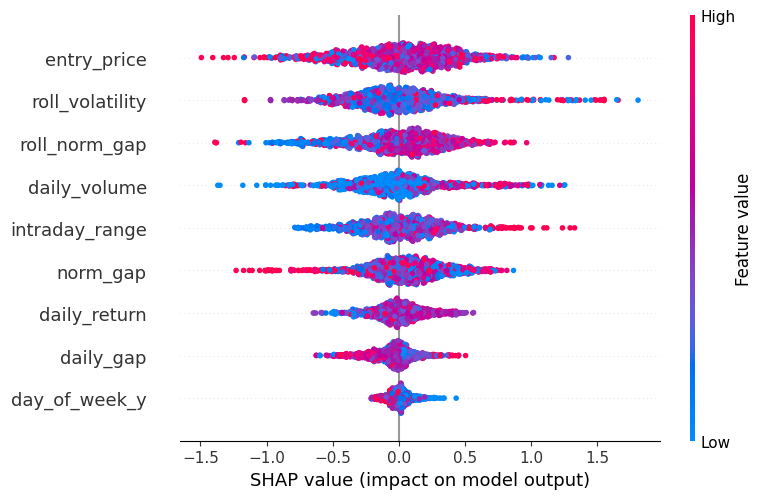

In [312]:
# Create SHAP explainer
explainer = shap.TreeExplainer(trained_clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot for the first class (if binary classification)
shap.summary_plot(shap_values[1], X_train)

In [313]:
# Results Primary

primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.52      1.00      0.68       192

    accuracy                           0.52       372
   macro avg       0.26      0.50      0.34       372
weighted avg       0.27      0.52      0.35       372

Confusion Matrix
[[  0 180]
 [  0 192]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [314]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_test)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_test, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_test, y_pred))

Confusion Matrix for Direct Predictions:
[[ 78 102]
 [ 92 100]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.46      0.43      0.45       180
           1       0.50      0.52      0.51       192

    accuracy                           0.48       372
   macro avg       0.48      0.48      0.48       372
weighted avg       0.48      0.48      0.48       372



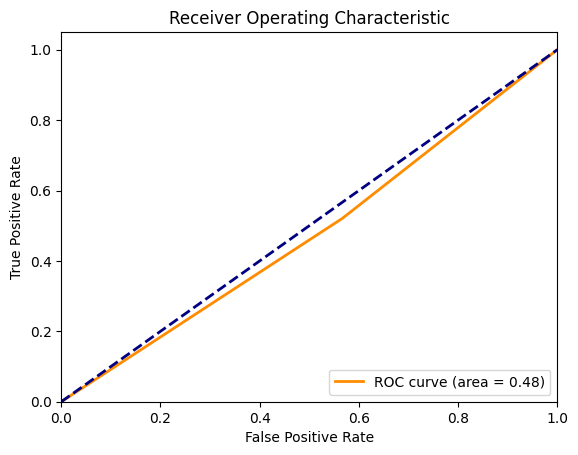

In [315]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [316]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.7).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_test, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[131  49]
 [142  50]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.48      0.73      0.58       180
           1       0.51      0.26      0.34       192

    accuracy                           0.49       372
   macro avg       0.49      0.49      0.46       372
weighted avg       0.49      0.49      0.46       372



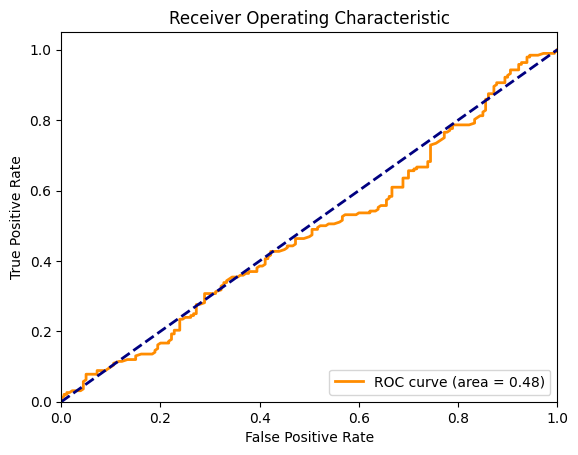

In [317]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Model Performance Changes
      Metric  Primary Model  Secondary Model  Change (%)
0  Precision         0.5161           0.5108     -1.0342
1     Recall         1.0000           0.3698    -63.0208
2   F1-Score         0.6809           0.4290    -36.9902
3   Accuracy         0.5161           0.4919     -4.6875
4        AUC         0.5000           0.4810     -3.7905


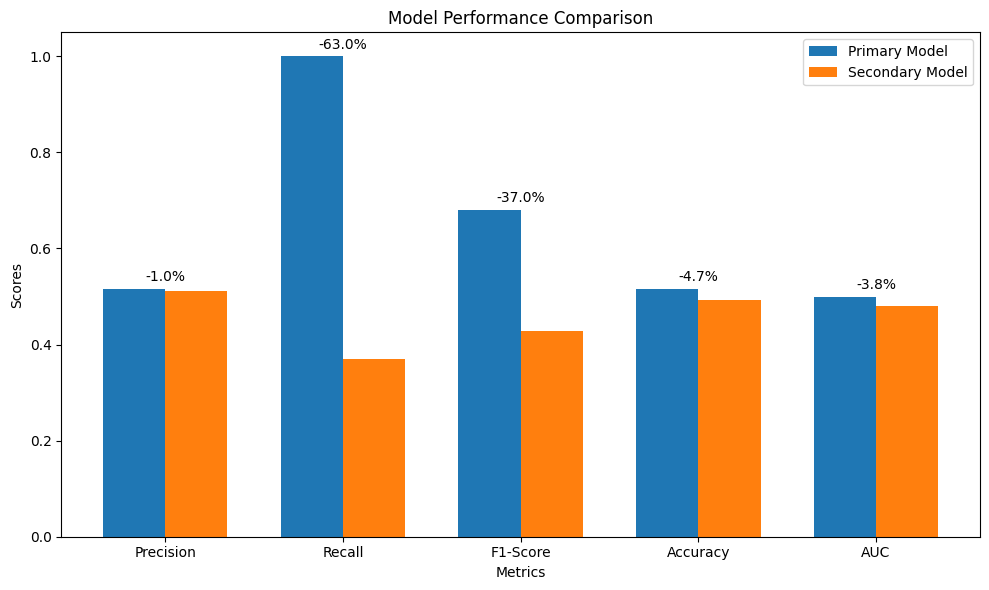

In [318]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Secondary model predictions
# Assuming clf and X_test are defined elsewhere
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred_threshold = (y_pred_proba >= 0.6).astype(int)

# Calculate performance metrics for primary model
precision_primary, recall_primary, f1_primary, _ = precision_recall_fscore_support(primary_forecast['actual'], primary_forecast['pred'], average=None, labels=[1])
accuracy_primary = accuracy_score(primary_forecast['actual'], primary_forecast['pred'])
# For the primary model, since the prediction is always 1, the AUC is not applicable
auc_primary = roc_auc_score(primary_forecast['actual'], primary_forecast['pred'])

# Calculate performance metrics for secondary model
precision_secondary, recall_secondary, f1_secondary, _ = precision_recall_fscore_support(y_test, y_pred_threshold, average=None, labels=[1])
accuracy_secondary = accuracy_score(y_test, y_pred_threshold)
auc_secondary = roc_auc_score(y_test, y_pred_proba)  # Use probabilities for AUC calculation

# Calculate percentage changes
precision_change = ((precision_secondary - precision_primary) / precision_primary) * 100
recall_change = ((recall_secondary - recall_primary) / recall_primary) * 100
f1_change = ((f1_secondary - f1_primary) / f1_primary) * 100
accuracy_change = ((accuracy_secondary - accuracy_primary) / accuracy_primary) * 100
auc_change = ((auc_secondary - auc_primary) / auc_primary) * 100 if auc_primary != 0 else 0

# Create a DataFrame for the changes
changes_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'AUC'],
    'Primary Model': [precision_primary[0], recall_primary[0], f1_primary[0], accuracy_primary, auc_primary],
    'Secondary Model': [precision_secondary[0], recall_secondary[0], f1_secondary[0], accuracy_secondary, auc_secondary],
    'Change (%)': [precision_change[0], recall_change[0], f1_change[0], accuracy_change, auc_change]
})

# Print the DataFrame to the console
print("Model Performance Changes")
print(changes_df)

# Plotting the changes
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(changes_df))

bar1 = ax.bar(index, changes_df['Primary Model'], bar_width, label='Primary Model')
bar2 = ax.bar(index + bar_width, changes_df['Secondary Model'], bar_width, label='Secondary Model')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(changes_df['Metric'])
ax.legend()

# Adding percentage change annotations
for i in range(len(changes_df)):
    ax.text(i + bar_width / 2, max(changes_df['Primary Model'][i], changes_df['Secondary Model'][i]) + 0.01,
            f"{changes_df['Change (%)'][i]:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Financials

In [319]:
import numpy as np
import pandas as pd

ypred = trained_clf.predict_proba(X_test)[:,1]
column_names = test_set.columns.to_list()
column_names.append("pred")
test_set_with_preds = pd.DataFrame(data = np.c_[test_set.to_numpy(), ypred])
test_set_with_preds.columns = column_names

# Assuming `test_set_with_preds` DataFrame is already created as shown in your context

# Primary Model: Predictions are all 1
primary_model_profits = test_set_with_preds["profit"]

# Secondary Model: Predictions with a threshold of 0.6
secondary_model_profits = test_set_with_preds[test_set_with_preds["pred"] > 0.6]["profit"]

# Calculate mean and standard deviation for primary model
primary_mean_profit = primary_model_profits.mean()
primary_std_profit = primary_model_profits.std()

# Calculate mean and standard deviation for secondary model
secondary_mean_profit = secondary_model_profits.mean()
secondary_std_profit = secondary_model_profits.std()

# Calculate the differences
mean_profit_difference = secondary_mean_profit - primary_mean_profit
std_profit_difference = secondary_std_profit - primary_std_profit

# Print the results
print("Mean Profit Difference (Secondary - Primary):", mean_profit_difference)
print("Standard Deviation of Profit Difference (Secondary - Primary):", std_profit_difference)


Mean Profit Difference (Secondary - Primary): 3.598920320871022e-05
Standard Deviation of Profit Difference (Secondary - Primary): 0.00035011337726275314


In [320]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Define function to calculate daily returns
def calculate_daily_returns(prices):
    return prices['prccd'].pct_change().fillna(0)

# Define function to calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    if len(returns) > 1:  # Ensure there are enough returns to calculate statistics
        excess_returns = returns - risk_free_rate
        return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    else:
        return np.nan  # Return NaN if not enough data

# Define function to calculate maximum drawdown
def calculate_max_drawdown(returns):
    if len(returns) > 1:
        cumulative_returns = (1 + returns).cumprod()
        running_max = cumulative_returns.cummax()
        drawdowns = (running_max - cumulative_returns) / running_max
        return drawdowns.max()
    else:
        return np.nan

# Define function to calculate annualized returns
def calculate_annualized_returns(returns):
    if len(returns) > 1:
        cumulative_return = (1 + returns).prod()
        return cumulative_return ** (252 / len(returns)) - 1
    else:
        return np.nan

# Define function to calculate annualized standard deviation
def calculate_annualized_stdev(returns):
    if len(returns) > 1:
        return np.std(returns) * np.sqrt(252)
    else:
        return np.nan

# Merge test_set_with_preds with raw to include 'cusip' and 'exit_date'
merged_trades = test_set_with_preds


# Initialize lists to store the metrics for boxplots
metrics_primary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}
metrics_secondary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}

# Iterate over each asset in the merged trades
for asset, group in merged_trades.groupby(['gvkey', 'cusip']):
    cusip = group['cusip'].iloc[0]

    # Load daily price data for the asset
    price_data_path = f"data/trading_daily/{cusip}.csv"
    if os.path.exists(price_data_path):
        price_data = pd.read_csv(price_data_path, parse_dates=['datadate'])
        price_data.set_index('datadate', inplace=True)

        # Calculate daily returns
        price_data['daily_return'] = calculate_daily_returns(price_data)

        # Filter trade periods beforehand for the primary strategy
        primary_trade_dates = pd.DatetimeIndex([])
        for _, trade in group.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            primary_trade_dates = primary_trade_dates.append(trade_dates)

        # Filtered returns for primary strategy
        primary_trade_returns = price_data.loc[primary_trade_dates, 'daily_return']

        # Calculate metrics for the primary strategy if trades occurred
        if not primary_trade_returns.empty:
            metrics_primary['Sharpe Ratio'].append(calculate_sharpe_ratio(primary_trade_returns))
            metrics_primary['Max Drawdown'].append(calculate_max_drawdown(primary_trade_returns))
            metrics_primary['Annualized Return'].append(calculate_annualized_returns(primary_trade_returns))
            metrics_primary['Annualized Stdev'].append(calculate_annualized_stdev(primary_trade_returns))

        # Filter trade periods beforehand for the secondary strategy
        secondary_trades = group[group['pred'] > 0.6]
        secondary_trade_dates = pd.DatetimeIndex([])
        for _, trade in secondary_trades.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            secondary_trade_dates = secondary_trade_dates.append(trade_dates)

        # Filtered returns for secondary strategy
        secondary_trade_returns = price_data.loc[secondary_trade_dates, 'daily_return']

        # Calculate metrics for the secondary strategy if trades occurred
        if not secondary_trade_returns.empty:
            metrics_secondary['Sharpe Ratio'].append(calculate_sharpe_ratio(secondary_trade_returns))
            metrics_secondary['Max Drawdown'].append(calculate_max_drawdown(secondary_trade_returns))
            metrics_secondary['Annualized Return'].append(calculate_annualized_returns(secondary_trade_returns))
            metrics_secondary['Annualized Stdev'].append(calculate_annualized_stdev(secondary_trade_returns))

# Convert NaN values to 0 for plotting
for metric in metrics_primary:
    metrics_primary[metric] = np.nan_to_num(metrics_primary[metric], nan=0.0)

for metric in metrics_secondary:
    metrics_secondary[metric] = np.nan_to_num(metrics_secondary[metric], nan=0.0)

# Plotting boxplots for each metric
metrics = ['Sharpe Ratio', 'Max Drawdown', 'Annualized Return', 'Annualized Stdev']




KeyError: 'gvkey'

In [308]:
def winsorize(series, lower_quantile=0.10, upper_quantile=0.90):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply Winsorization
for metric in metrics_primary:
    metrics_primary[metric] = winsorize(pd.Series(metrics_primary[metric]))
for metric in metrics_secondary:
    metrics_secondary[metric] = winsorize(pd.Series(metrics_secondary[metric]))


# Convert the metrics dictionaries to DataFrames
primary_metrics_df = pd.DataFrame(metrics_primary)
secondary_metrics_df = pd.DataFrame(metrics_secondary)

# Output descriptive statistics
print("Primary Metrics Descriptive Statistics:")
print(primary_metrics_df.describe())

print("\nSecondary Metrics Descriptive Statistics:")
print(secondary_metrics_df.describe())

Primary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     4157.0000     4157.0000          4157.0000         4157.0000
mean        -1.4572        0.4638            -0.4422            0.4910
std          1.5266        0.1774             0.3497            0.2086
min         -4.6411        0.1984            -0.9845            0.2364
25%         -2.2169        0.3179            -0.7645            0.3165
50%         -1.0600        0.4535            -0.3842            0.4390
75%         -0.2988        0.6091            -0.1451            0.6433
max          0.3363        0.7487             0.0423            0.8780

Secondary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     3100.0000     3100.0000          3100.0000         3100.0000
mean        -0.7922        0.2260            -0.1445            0.3348
std          1.8479        0.1131             0.4864            0

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


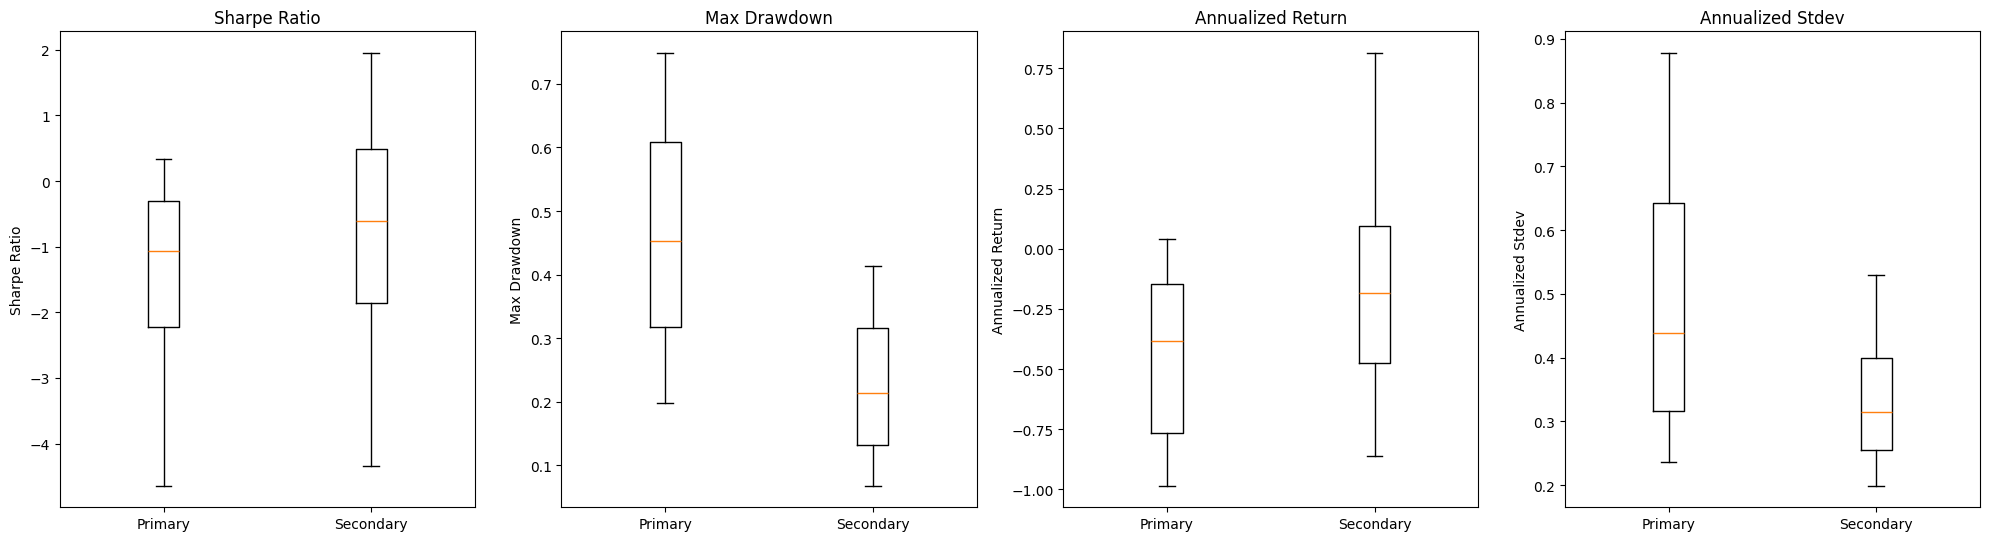

In [309]:


fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.boxplot([metrics_primary[metric], metrics_secondary[metric]], labels=['Primary', 'Secondary'])
    ax.set_title(metric)
    ax.set_ylabel(metric)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Experiment 2: False Negatives

In [310]:
# columns_train = [ 'indret_vw', 'ptb',
#        'frac_diff_close', 'CrudeOil_Vol', 'bm', 'indret_ew', 'Silver_Daily_Vol',
#         'NASDAQ_Vol', 'to_earnings', 'std', 'Gold', 'HMA_2', 'Silver', 'Treasury_Yield4', 'USDIndex', 'z_score',
#        'max_ret', 'NATR_4', 'STDEV_1', 'garch_vol_close', 
#        'from_earnings', 'Gold_Daily_Vol', 'treasury_yield1_vol', 'open','high','low','close','volume','bb_20_2_bbmid','bb_20_2_bbupper','bb_20_2_bblower','bb_20_2_percentb','bb_20_2_bbwidth']

columns_train = ['indret_vw', 'ptb', 'frac_diff_close', 'CrudeOil_Vol', 'bm', 'indret_ew',
 'NASDAQ_Vol',  'HMA_2', 'z_score',  'NATR_4',
 'from_earnings', 'Gold_Daily_Vol', 'treasury_yield1_vol',  'bb_20_2_bbwidth']


In [311]:
X_train = train_set.loc[:, columns_train]

y_train = train_set.loc[:, 'profit_binary']
y_train = y_train.astype(int)


In [312]:
X_test = test_set.loc[:, columns_train]
y_test = test_set.loc[:, 'profit_binary']
y_test = y_test.astype(int)

In [313]:
y_train.value_counts()

1    41837
0    33214
Name: profit_binary, dtype: int64

In [314]:
# Replace -inf and inf in X_train
X_train = X_train.replace([np.inf, -np.inf], np.nan)  # Temporarily replace inf and -inf with NaN
max_value_train = X_train.max().max()  # Find the maximum finite value
min_value_train = X_train.min().min()  # Find the minimum finite value

X_train = X_train.fillna(max_value_train).replace(-np.inf, min_value_train)  # Replace NaN with max value and -inf with min value

# Replace -inf and inf in X_test
X_test = X_test.replace([np.inf, -np.inf], np.nan)  # Temporarily replace inf and -inf with NaN
max_value_test = X_test.max().max()  # Find the maximum finite value
min_value_test = X_test.min().min()  # Find the minimum finite value

X_test = X_test.fillna(max_value_test).replace(-np.inf, min_value_test)  # Replace NaN with max value and -inf with min value


In [315]:
X_test.describe()

,indret_vw,ptb,frac_diff_close,CrudeOil_Vol,bm,indret_ew,NASDAQ_Vol,HMA_2,z_score,NATR_4,from_earnings,Gold_Daily_Vol,treasury_yield1_vol,bb_20_2_bbwidth
count,41751.0000,41751.0000,41751.0000,41751.0000,41751.0000,41751.0000,41751.0000,41751.0000,41751.0000,41751.0000,41751.0000,41751.0000,41751.0000,41751.0000
mean,-0.0163,3.5956,7.8928,0.2098,0.3993,-0.0252,0.0588,-0.0596,-1.1012,4.8940,34.3065,0.0393,0.4415,0.1313
std,0.0556,7.3650,613.3806,0.0997,0.5061,0.0677,0.0263,0.0918,558.1225,5.3418,27.7366,0.0117,0.2469,0.0934
min,-0.3710,0.0000,-13056.6719,0.0696,0.0000,-0.4462,0.0199,-3.9099,-458.1359,0.1369,0.0000,0.0176,0.0757,0.0020
25%,-0.0506,0.0000,-0.0358,0.1473,0.0000,-0.0668,0.0397,-0.0716,-4.2104,2.6251,13.0000,0.0309,0.2483,0.0702
50%,-0.0124,1.5420,0.9416,0.1943,0.2630,-0.0225,0.0542,-0.0403,-3.1738,3.8606,30.0000,0.0379,0.4120,0.1078
75%,0.0186,3.5565,3.3834,0.2527,0.6100,0.0097,0.0735,-0.0209,-2.5167,5.9196,49.0000,0.0450,0.5920,0.1653
max,0.3253,99.6690,114035.0877,1.3794,17.6690,0.5725,0.2691,0.7059,114035.0877,469.3838,556.0000,0.1243,1.5481,1.2620


### Train Meta Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
cfg = {
    "num_threads": 8,
    "boosting_type": "gbdt",
    "lambda_l1": 2.8269687100646643,
    "lambda_l2": 0.1132729746179371,
    "num_leaves": 100,
    #"num_leaves": 222,
    "feature_fraction": 0.6029600980261194,
    "bagging_fraction": 0.9924346775670325,
    "bagging_freq": 2,
    "min_child_samples": 65,
    "max_depth": 14,
    "max_bin": 136,
    "learning_rate": 0.30197097330510875,
    "importance_type": "gain"
}

clf = lgb.LGBMClassifier(seed=42)

clf.set_params(**cfg)

# clf = RandomForestClassifier(random_state=42, n_jobs=-1)
trained_clf = clf.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.1132729746179371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1132729746179371
[LightGBM] [Warning] feature_fraction is set=0.6029600980261194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029600980261194
[LightGBM] [Warning] bagging_fraction is set=0.9924346775670325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9924346775670325
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] lambda_l1 is set=2.8269687100646643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8269687100646643


In [266]:
X_train

,day_of_week_y,entry_price
date,,
2020-01-06 08:00:00+00:00,6.0000,1572.2550
2020-01-06 15:36:00+00:00,6.0000,1564.3937
2020-01-07 08:00:00+00:00,0.0000,1569.4480
2020-01-08 08:00:00+00:00,1.0000,1588.5380
2020-01-08 08:59:00+00:00,1.0000,1580.5953
...,...,...
2023-11-09 14:58:00+00:00,2.0000,1958.6998
2023-11-10 08:00:00+00:00,3.0000,1954.9050
2023-11-13 08:00:00+00:00,6.0000,1939.0450


In [ ]:
ypred = trained_clf.predict(X_train)
ypred
pred_df = pd.DataFrame(data = [ypred, y_train.to_numpy()]).T
pred_df.columns = ["prediction", "target"]
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_train)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_train, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_train, y_pred))

Confusion Matrix for Direct Predictions:
[[512 248]
 [371 355]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.58      0.67      0.62       760
           1       0.59      0.49      0.53       726

    accuracy                           0.58      1486
   macro avg       0.58      0.58      0.58      1486
weighted avg       0.58      0.58      0.58      1486



In [ ]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_train)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.8).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_train, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_train, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[760   0]
 [726   0]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       760
           1       0.00      0.00      0.00       726

    accuracy                           0.51      1486
   macro avg       0.26      0.50      0.34      1486
weighted avg       0.26      0.51      0.35      1486



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

# Assuming `trained_clf` is your trained model and `X_train` is your training data

# Gain-based feature importance
gain_importance = trained_clf.booster_.feature_importance(importance_type='gain')
gain_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': gain_importance})
print("Gain-based feature importance:\n", gain_importance_df)

# Split-based feature importance
split_importance = trained_clf.booster_.feature_importance(importance_type='split')
split_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': split_importance})
print("Split-based feature importance:\n", split_importance_df)

# Permutation importance (optional and more computationally expensive)
perm_importance = permutation_importance(trained_clf, X_train, y_train, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importance.importances_mean})
print("Permutation feature importance:\n", perm_importance_df)

# Plotting feature importance (optional)
import matplotlib.pyplot as plt

# Plot gain-based feature importance
gain_importance_df = gain_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(gain_importance_df['feature'], gain_importance_df['importance'])
plt.xlabel('Gain Importance')
plt.ylabel('Features')
plt.title('Feature Importance by Gain')
plt.gca().invert_yaxis()
plt.show()

# Plot split-based feature importance
split_importance_df = split_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(split_importance_df['feature'], split_importance_df['importance'])
plt.xlabel('Split Importance')
plt.ylabel('Features')
plt.title('Feature Importance by Split')
plt.gca().invert_yaxis()
plt.show()


# Get top 20 features by Gain-based importance
top20_gain = gain_importance_df.sort_values(by='importance', ascending=False).head(50)
print("Top 20 features by Gain-based importance:\n", top20_gain)

# Get top 20 features by Split-based importance
top20_split = split_importance_df.sort_values(by='importance', ascending=False).head(50)
print("Top 20 features by Split-based importance:\n", top20_split)

# Get top 20 features by Permutation importance
top20_perm = perm_importance_df.sort_values(by='importance', ascending=False).head(50)
print("Top 20 features by Permutation importance:\n", top20_perm)

# Find the common top 20 features across all methods
common_top20_features = set(top20_gain['feature']).intersection(top20_split['feature'], top20_perm['feature'])
print("Top 20 features that scored well in all methods:\n", common_top20_features)

# Convert common top 20 features to DataFrame for display
common_top20_features_df = pd.DataFrame(common_top20_features, columns=['feature'])
print("Common top 20 features across all methods:\n", common_top20_features_df)


In [269]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Define function to calculate daily returns
def calculate_daily_returns(prices):
    return prices['prccd'].pct_change().fillna(0)

# Define function to calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    if len(returns) > 1:  # Ensure there are enough returns to calculate statistics
        excess_returns = returns - risk_free_rate
        return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    else:
        return np.nan  # Return NaN if not enough data

# Define function to calculate maximum drawdown
def calculate_max_drawdown(returns):
    if len(returns) > 1:
        cumulative_returns = (1 + returns).cumprod()
        running_max = cumulative_returns.cummax()
        drawdowns = (running_max - cumulative_returns) / running_max
        return drawdowns.max()
    else:
        return np.nan

# Define function to calculate annualized returns
def calculate_annualized_returns(returns):
    if len(returns) > 1:
        cumulative_return = (1 + returns).prod()
        return cumulative_return ** (252 / len(returns)) - 1
    else:
        return np.nan

# Define function to calculate annualized standard deviation
def calculate_annualized_stdev(returns):
    if len(returns) > 1:
        return np.std(returns) * np.sqrt(252)
    else:
        return np.nan

# Merge test_set_with_preds with raw to include 'cusip' and 'exit_date'
merged_trades = pd.merge(
    test_set_with_preds,
    raw[['date', 'exit_date', 'gvkey', 'cusip']],
    on=['date', 'gvkey'],
    how='left'
)

# Determine the overall date range from the entire test_set_with_preds
overall_start_date = merged_trades['date'].min()
overall_end_date = merged_trades['exit_date'].max()

# Initialize lists to store the metrics for boxplots
metrics_primary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}
metrics_secondary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}

# Iterate over each asset in the merged trades
for asset, group in merged_trades.groupby(['gvkey', 'cusip']):
    cusip = group['cusip'].iloc[0]

    # Load daily price data for the asset
    price_data_path = f"data/trading_daily/{cusip}.csv"
    if os.path.exists(price_data_path):
        price_data = pd.read_csv(price_data_path, parse_dates=['datadate'])
        price_data.set_index('datadate', inplace=True)

        # Calculate daily returns
        price_data['daily_return'] = calculate_daily_returns(price_data)

        # Filter trade periods beforehand for the primary strategy
        primary_trade_dates = pd.DatetimeIndex([])
        for _, trade in group.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            primary_trade_dates = primary_trade_dates.append(trade_dates)

        # Filtered returns for primary strategy
        primary_trade_returns = price_data.loc[primary_trade_dates, 'daily_return']

        # Calculate metrics for the primary strategy if trades occurred
        if not primary_trade_returns.empty:
            metrics_primary['Sharpe Ratio'].append(calculate_sharpe_ratio(primary_trade_returns))
            metrics_primary['Max Drawdown'].append(calculate_max_drawdown(primary_trade_returns))
            metrics_primary['Annualized Return'].append(calculate_annualized_returns(primary_trade_returns))
            metrics_primary['Annualized Stdev'].append(calculate_annualized_stdev(primary_trade_returns))

        # Filter trade periods beforehand for the secondary strategy
        secondary_trades = group[group['pred'] > 0.6]
        secondary_trade_dates = pd.DatetimeIndex([])
        for _, trade in secondary_trades.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            secondary_trade_dates = secondary_trade_dates.append(trade_dates)

        # Filtered returns for secondary strategy
        secondary_trade_returns = price_data.loc[secondary_trade_dates, 'daily_return']

        # Calculate metrics for the secondary strategy if trades occurred
        if not secondary_trade_returns.empty:
            metrics_secondary['Sharpe Ratio'].append(calculate_sharpe_ratio(secondary_trade_returns))
            metrics_secondary['Max Drawdown'].append(calculate_max_drawdown(secondary_trade_returns))
            metrics_secondary['Annualized Return'].append(calculate_annualized_returns(secondary_trade_returns))
            metrics_secondary['Annualized Stdev'].append(calculate_annualized_stdev(secondary_trade_returns))

# Convert NaN values to 0 for plotting
for metric in metrics_primary:
    metrics_primary[metric] = np.nan_to_num(metrics_primary[metric], nan=0.0)

for metric in metrics_secondary:
    metrics_secondary[metric] = np.nan_to_num(metrics_secondary[metric], nan=0.0)

# Plotting boxplots for each metric
metrics = ['Sharpe Ratio', 'Max Drawdown', 'Annualized Return', 'Annualized Stdev']




KeyError: "None of [Index(['date', 'exit_date', 'gvkey', 'cusip'], dtype='object')] are in the [columns]"

In [321]:
def winsorize(series, lower_quantile=0.10, upper_quantile=0.90):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply Winsorization
for metric in metrics_primary:
    metrics_primary[metric] = winsorize(pd.Series(metrics_primary[metric]))
for metric in metrics_secondary:
    metrics_secondary[metric] = winsorize(pd.Series(metrics_secondary[metric]))


# Convert the metrics dictionaries to DataFrames
primary_metrics_df = pd.DataFrame(metrics_primary)
secondary_metrics_df = pd.DataFrame(metrics_secondary)

# Output descriptive statistics
print("Primary Metrics Descriptive Statistics:")
print(primary_metrics_df.describe())

print("\nSecondary Metrics Descriptive Statistics:")
print(secondary_metrics_df.describe())

Primary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     4157.0000     4157.0000          4157.0000         4157.0000
mean        -1.4572        0.4638            -0.4422            0.4910
std          1.5266        0.1774             0.3497            0.2086
min         -4.6411        0.1984            -0.9845            0.2364
25%         -2.2169        0.3179            -0.7645            0.3165
50%         -1.0600        0.4535            -0.3842            0.4390
75%         -0.2988        0.6091            -0.1451            0.6433
max          0.3363        0.7487             0.0423            0.8780

Secondary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     3100.0000     3100.0000          3100.0000         3100.0000
mean        -0.7922        0.2260            -0.1445            0.3348
std          1.8479        0.1131             0.4864            0

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


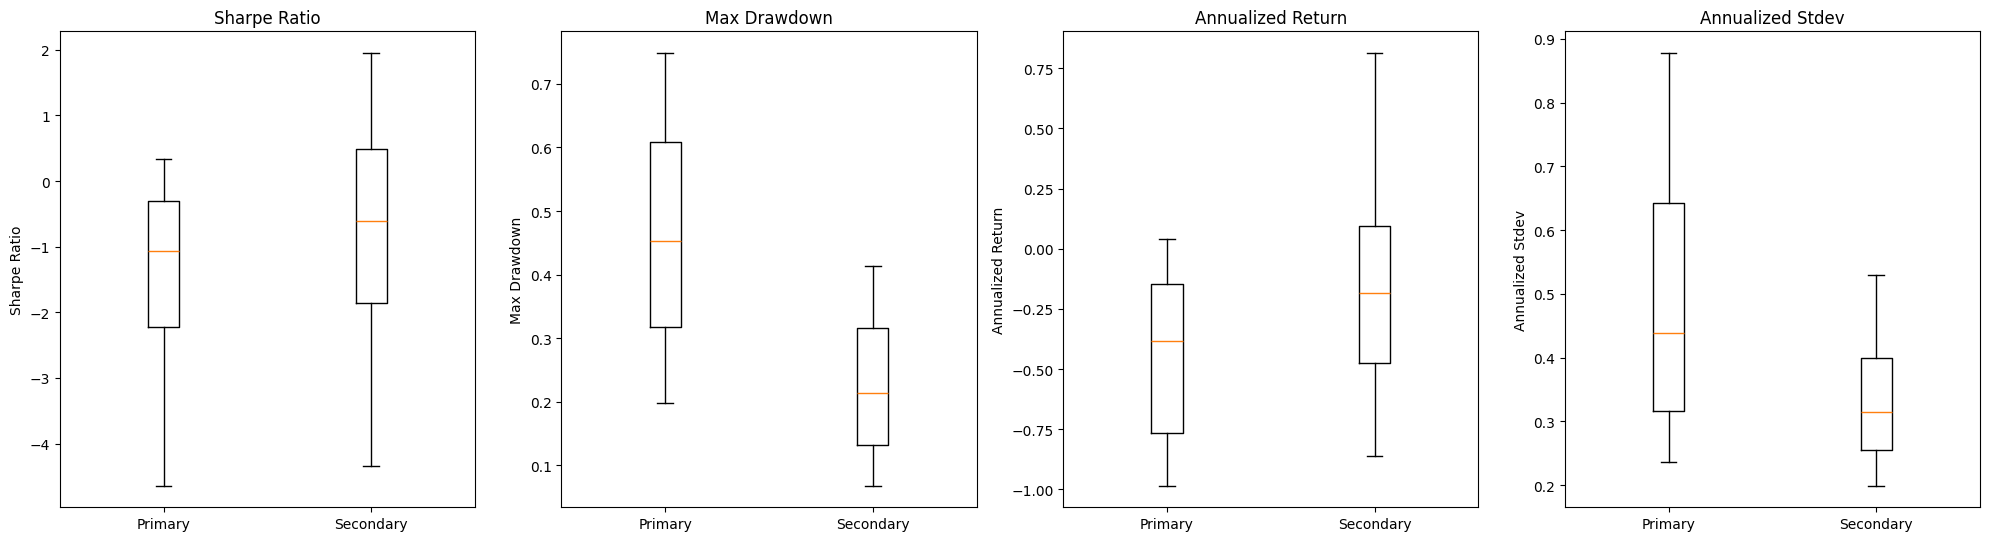

In [322]:


fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.boxplot([metrics_primary[metric], metrics_secondary[metric]], labels=['Primary', 'Secondary'])
    ax.set_title(metric)
    ax.set_ylabel(metric)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


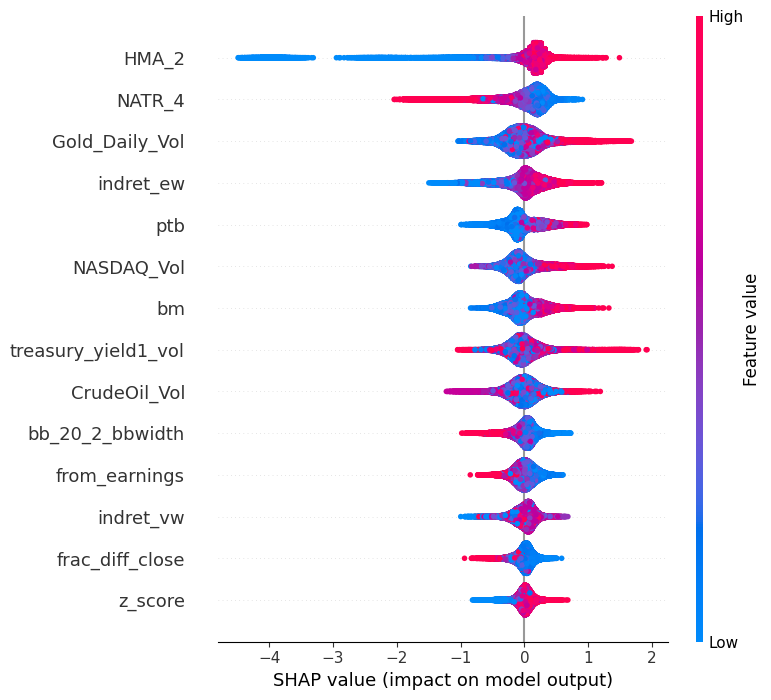

In [323]:
# Create SHAP explainer
explainer = shap.TreeExplainer(trained_clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot for the first class (if binary classification)
shap.summary_plot(shap_values[1], X_train)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_train.iloc[0])


# Test

In [324]:
# Results Primary

primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21948
           1       0.47      1.00      0.64     19803

    accuracy                           0.47     41751
   macro avg       0.24      0.50      0.32     41751
weighted avg       0.22      0.47      0.31     41751

Confusion Matrix
[[    0 21948]
 [    0 19803]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [325]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_test)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_test, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_test, y_pred))

Confusion Matrix for Direct Predictions:
[[11908 10040]
 [ 6818 12985]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.64      0.54      0.59     21948
           1       0.56      0.66      0.61     19803

    accuracy                           0.60     41751
   macro avg       0.60      0.60      0.60     41751
weighted avg       0.60      0.60      0.60     41751



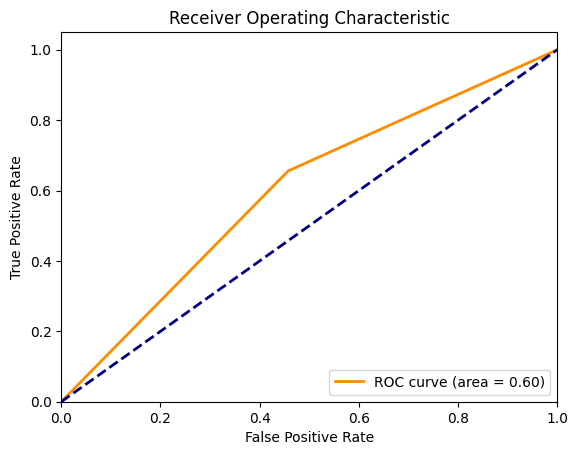

In [326]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [327]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.6).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_test, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[14454  7494]
 [ 9820  9983]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.60      0.66      0.63     21948
           1       0.57      0.50      0.54     19803

    accuracy                           0.59     41751
   macro avg       0.58      0.58      0.58     41751
weighted avg       0.58      0.59      0.58     41751



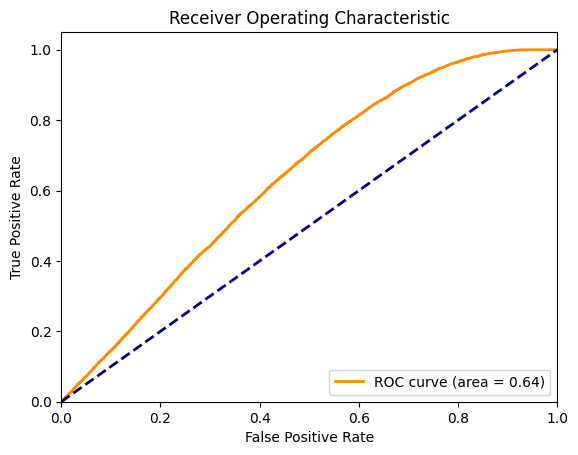

In [328]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [329]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.9 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.9).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.9 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.9 Threshold:")
print(classification_report(y_test, y_pred_threshold))

Confusion Matrix with 0.9 Threshold:
[[21395   553]
 [19084   719]]

Classification Report with 0.9 Threshold:
              precision    recall  f1-score   support

           0       0.53      0.97      0.69     21948
           1       0.57      0.04      0.07     19803

    accuracy                           0.53     41751
   macro avg       0.55      0.51      0.38     41751
weighted avg       0.55      0.53      0.39     41751



Model Performance Changes
      Metric  Primary Model  Secondary Model  Change (%)
0  Precision         0.4743           0.5712     20.4287
1     Recall         1.0000           0.5041    -49.5884
2   F1-Score         0.6434           0.5356    -16.7641
3   Accuracy         0.4743           0.5853     23.4005
4        AUC         0.5000           0.6372     27.4405


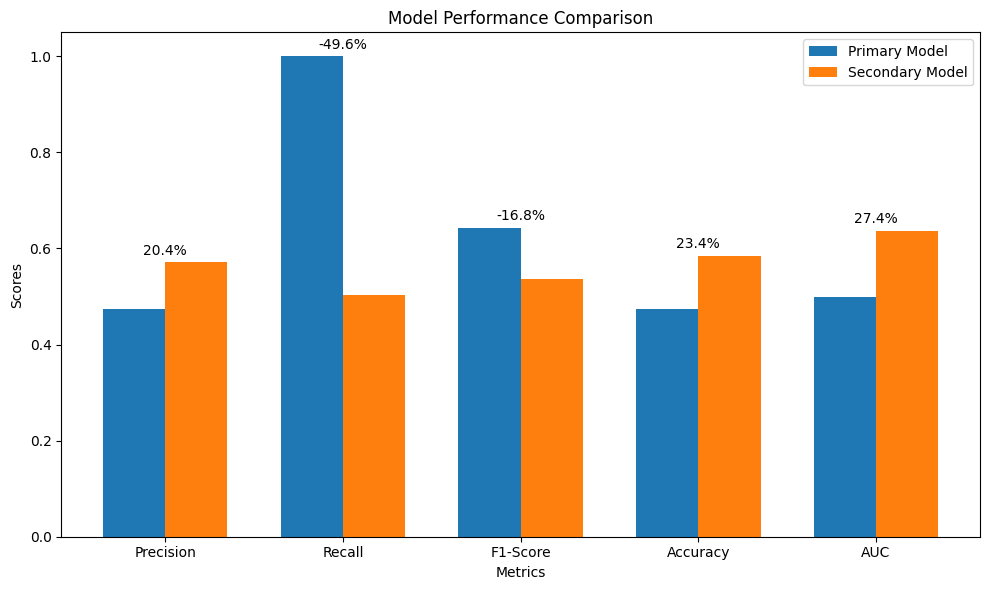

In [330]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Secondary model predictions
# Assuming clf and X_test are defined elsewhere
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred_threshold = (y_pred_proba >= 0.6).astype(int)

# Calculate performance metrics for primary model
precision_primary, recall_primary, f1_primary, _ = precision_recall_fscore_support(primary_forecast['actual'], primary_forecast['pred'], average=None, labels=[1])
accuracy_primary = accuracy_score(primary_forecast['actual'], primary_forecast['pred'])
# For the primary model, since the prediction is always 1, the AUC is not applicable
auc_primary = roc_auc_score(primary_forecast['actual'], primary_forecast['pred'])

# Calculate performance metrics for secondary model
precision_secondary, recall_secondary, f1_secondary, _ = precision_recall_fscore_support(y_test, y_pred_threshold, average=None, labels=[1])
accuracy_secondary = accuracy_score(y_test, y_pred_threshold)
auc_secondary = roc_auc_score(y_test, y_pred_proba)  # Use probabilities for AUC calculation

# Calculate percentage changes
precision_change = ((precision_secondary - precision_primary) / precision_primary) * 100
recall_change = ((recall_secondary - recall_primary) / recall_primary) * 100
f1_change = ((f1_secondary - f1_primary) / f1_primary) * 100
accuracy_change = ((accuracy_secondary - accuracy_primary) / accuracy_primary) * 100
auc_change = ((auc_secondary - auc_primary) / auc_primary) * 100 if auc_primary != 0 else 0

# Create a DataFrame for the changes
changes_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'AUC'],
    'Primary Model': [precision_primary[0], recall_primary[0], f1_primary[0], accuracy_primary, auc_primary],
    'Secondary Model': [precision_secondary[0], recall_secondary[0], f1_secondary[0], accuracy_secondary, auc_secondary],
    'Change (%)': [precision_change[0], recall_change[0], f1_change[0], accuracy_change, auc_change]
})

# Print the DataFrame to the console
print("Model Performance Changes")
print(changes_df)

# Plotting the changes
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(changes_df))

bar1 = ax.bar(index, changes_df['Primary Model'], bar_width, label='Primary Model')
bar2 = ax.bar(index + bar_width, changes_df['Secondary Model'], bar_width, label='Secondary Model')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(changes_df['Metric'])
ax.legend()

# Adding percentage change annotations
for i in range(len(changes_df)):
    ax.text(i + bar_width / 2, max(changes_df['Primary Model'][i], changes_df['Secondary Model'][i]) + 0.01,
            f"{changes_df['Change (%)'][i]:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [331]:
X_test

,indret_vw,ptb,frac_diff_close,CrudeOil_Vol,bm,indret_ew,NASDAQ_Vol,HMA_2,z_score,NATR_4,from_earnings,Gold_Daily_Vol,treasury_yield1_vol,bb_20_2_bbwidth
75051,0.0531,1.6980,0.9377,0.3816,0.4200,0.0987,0.0972,-0.0465,-2.6246,3.1711,46.0000,0.0235,0.3786,0.0679
75052,0.0824,1.3740,-14.0713,0.3816,0.4560,0.1548,0.0972,-0.5898,-8.5117,21.0980,44.0000,0.0235,0.3786,0.3362
75053,0.1630,0.0000,0.1979,0.3816,0.0000,0.1619,0.0972,-0.0274,-3.0284,2.9947,44.0000,0.0235,0.3786,0.0546
75054,0.1141,1.9390,11.3491,0.3660,0.6950,0.1368,0.0982,-0.0086,-3.8547,0.6246,27.0000,0.0225,0.4255,0.0112
75055,0.0824,0.0000,-4.9856,0.3660,0.0000,0.1548,0.0982,-0.1106,-2.9563,6.5734,46.0000,0.0225,0.4255,0.1097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116797,0.0773,9.2350,-5.1750,0.1246,0.0970,0.1073,0.0323,-0.1426,-8.5976,5.9835,49.0000,0.0467,0.7235,0.1786
116798,0.0742,0.0000,1.7280,0.1246,0.0000,0.1430,0.0323,-0.0211,-3.5295,1.2022,35.0000,0.0467,0.7235,0.0253
116799,0.0649,9.5810,5.2189,0.1246,0.1350,0.1221,0.0323,-0.0081,-2.3697,1.8220,43.0000,0.0467,0.7235,0.0679
116800,0.0803,3.6680,1.8576,0.1246,0.2690,0.1002,0.0323,-0.0167,-4.0661,1.2572,44.0000,0.0467,0.7235,0.0376


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


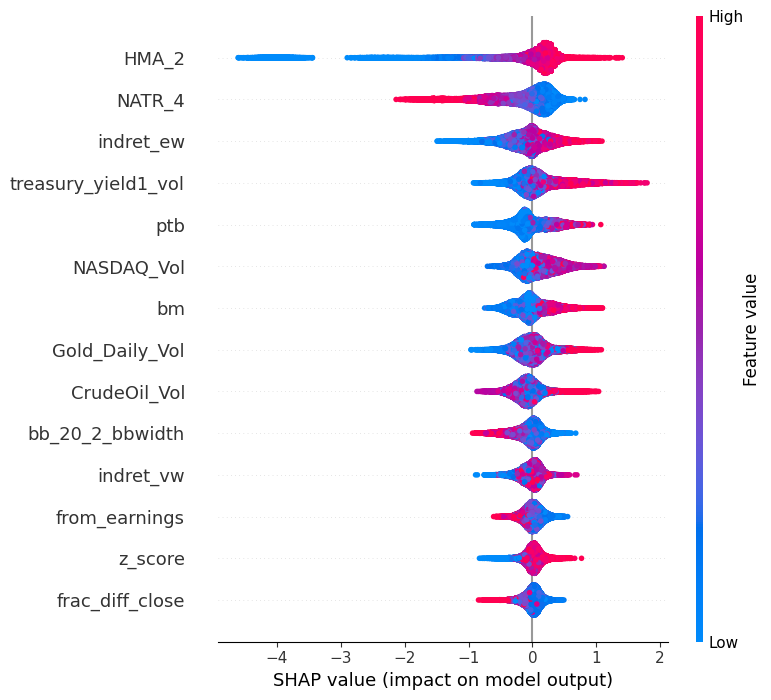

In [332]:
# Create SHAP explainer
explainer = shap.TreeExplainer(clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot for the first class (if binary classification)
shap.summary_plot(shap_values[1], X_test)



In [333]:
# compute SHAP values
explainer = shap.Explainer(clf, X_test)
explanation = explainer(X_test[:5000])



 97%|=================== | 4853/5000 [00:24<00:00]       

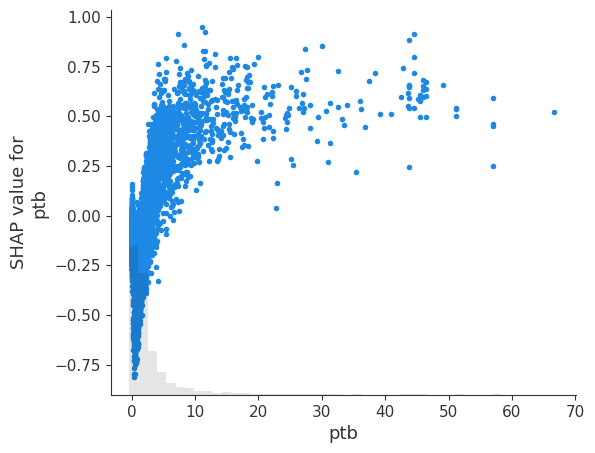

In [334]:
shap.plots.scatter(explanation[:, "ptb"])

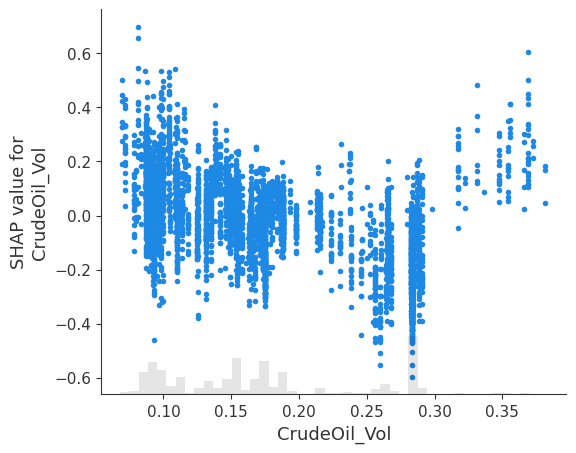

In [335]:
shap.plots.scatter(explanation[:, "CrudeOil_Vol"])

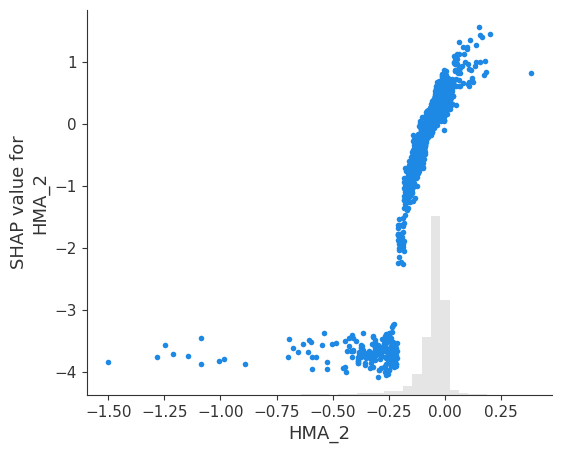

In [336]:
shap.plots.scatter(explanation[:, "HMA_2"])

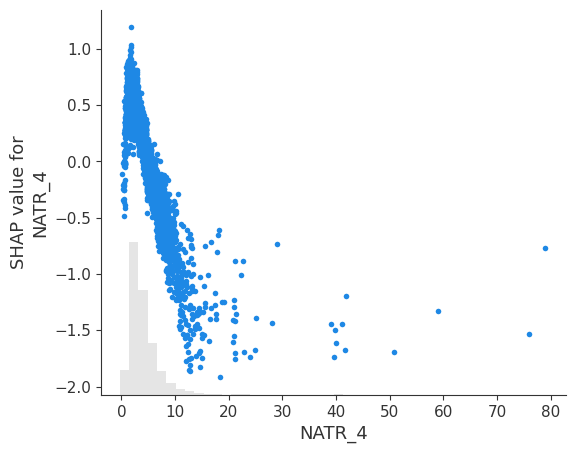

In [337]:
shap.plots.scatter(explanation[:, "NATR_4"])

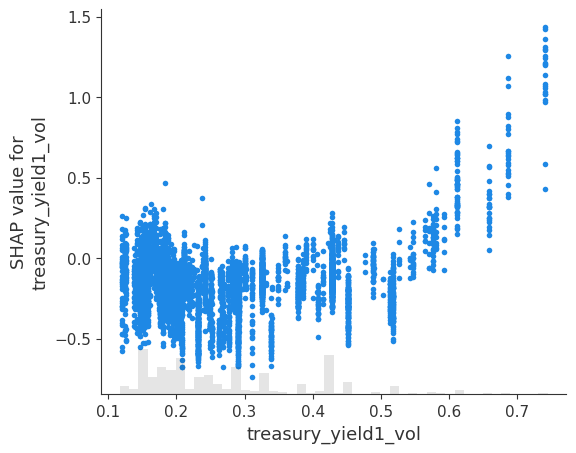

In [338]:
shap.plots.scatter(explanation[:, "treasury_yield1_vol"])

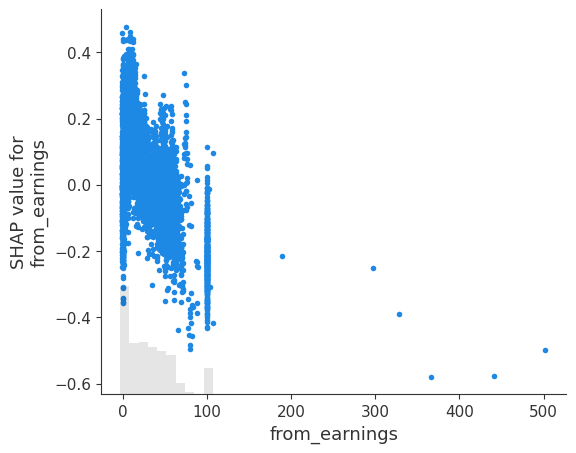

In [339]:
shap.plots.scatter(explanation[:, "from_earnings"])

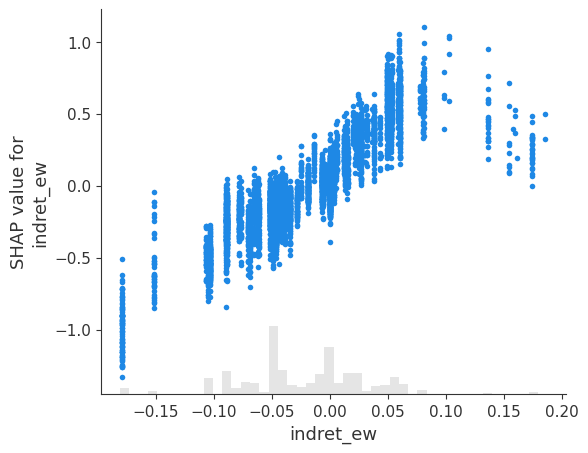

In [340]:
shap.plots.scatter(explanation[:, "indret_ew"])

In [341]:
shap_values_class1 = shap_values[1]

shap_df = pd.DataFrame(shap_values_class1, columns=X_test.columns)
feature_df = X_test.reset_index(drop=True)

# Calculate the correlation between each feature value and its corresponding SHAP value
correlations = {}

for column in feature_df.columns:
    corr = np.corrcoef(feature_df[column], shap_df[column])[0, 1]
    correlations[column] = corr

# Convert correlations to a DataFrame for better readability
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])

# Sort by absolute value of correlation
correlation_df = correlation_df.reindex(correlation_df['Correlation'].abs().sort_values(ascending=False).index)

# Display the correlation summary
print(correlation_df)

                Feature  Correlation
7                 HMA_2       0.7800
5             indret_ew       0.7779
13      bb_20_2_bbwidth      -0.7304
12  treasury_yield1_vol       0.7085
4                    bm       0.6445
9                NATR_4      -0.6306
10        from_earnings      -0.5742
1                   ptb       0.5448
6            NASDAQ_Vol       0.5411
11       Gold_Daily_Vol       0.5401
3          CrudeOil_Vol       0.2412
0             indret_vw       0.2398
2       frac_diff_close      -0.0377
8               z_score       0.0046


In [342]:
import numpy as np
import pandas as pd

# Assuming SHAP values are already calculated
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for the positive class (class 1)
shap_values_class1 = shap_values[1]

# Create a DataFrame with SHAP values and feature values
shap_df = pd.DataFrame(shap_values_class1, columns=X_test.columns)
feature_df = X_test.reset_index(drop=True)

# Define the percentiles
percentiles = [0.25, 0.5, 0.75, 1.0]

# Initialize a dictionary to store the results
percentile_shap_values = {}

# Calculate the average SHAP value at each percentile for each feature
for column in feature_df.columns:
    feature_percentiles = np.percentile(feature_df[column], [p*100 for p in percentiles])
    
    # Initialize a list to hold the mean SHAP values at each percentile
    shap_means = []
    
    for i in range(len(percentiles)):
        if i == 0:
            # Calculate mean SHAP value for feature values less than or equal to the first percentile
            shap_mean = shap_df[column][feature_df[column] <= feature_percentiles[i]].mean()
        else:
            # Calculate mean SHAP value for feature values between the current and previous percentiles
            shap_mean = shap_df[column][(feature_df[column] > feature_percentiles[i-1]) & (feature_df[column] <= feature_percentiles[i])].mean()
        
        shap_means.append(shap_mean)
    
    # Store the results
    percentile_shap_values[column] = shap_means

# Convert the dictionary to a DataFrame for better readability
shap_percentile_df = pd.DataFrame(percentile_shap_values, index=[f'{int(p*100)}th Percentile' for p in percentiles])

# Display the SHAP percentile summary
print(shap_percentile_df)


                  indret_vw     ptb  frac_diff_close  CrudeOil_Vol      bm  \
25th Percentile     -0.1144 -0.1214           0.0764        0.0089 -0.0444   
50th Percentile     -0.0018 -0.2993           0.0373       -0.1198 -0.2866   
75th Percentile      0.0597  0.0435           0.0026       -0.1382 -0.0145   
100th Percentile    -0.0514  0.3516          -0.1326       -0.0521  0.3016   

                  indret_ew  NASDAQ_Vol   HMA_2  z_score  NATR_4  \
25th Percentile     -0.3845     -0.1181 -1.0658  -0.1146  0.2411   
50th Percentile     -0.1607     -0.0654  0.0556  -0.0084  0.1372   
75th Percentile      0.0144      0.2804  0.2307   0.0555 -0.1355   
100th Percentile     0.3029      0.2840  0.2732   0.0994 -0.8109   

                  from_earnings  Gold_Daily_Vol  treasury_yield1_vol  \
25th Percentile          0.0832         -0.1156              -0.1450   
50th Percentile          0.0713         -0.1044              -0.0445   
75th Percentile         -0.0127          0.0207     

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [343]:
shap_percentile_df.to_csv('../data/shap_percentile.csv', index=False)


In [344]:
print(shap_percentile_df)

                  indret_vw     ptb  frac_diff_close  CrudeOil_Vol      bm  \
25th Percentile     -0.1144 -0.1214           0.0764        0.0089 -0.0444   
50th Percentile     -0.0018 -0.2993           0.0373       -0.1198 -0.2866   
75th Percentile      0.0597  0.0435           0.0026       -0.1382 -0.0145   
100th Percentile    -0.0514  0.3516          -0.1326       -0.0521  0.3016   

                  indret_ew  NASDAQ_Vol   HMA_2  z_score  NATR_4  \
25th Percentile     -0.3845     -0.1181 -1.0658  -0.1146  0.2411   
50th Percentile     -0.1607     -0.0654  0.0556  -0.0084  0.1372   
75th Percentile      0.0144      0.2804  0.2307   0.0555 -0.1355   
100th Percentile     0.3029      0.2840  0.2732   0.0994 -0.8109   

                  from_earnings  Gold_Daily_Vol  treasury_yield1_vol  \
25th Percentile          0.0832         -0.1156              -0.1450   
50th Percentile          0.0713         -0.1044              -0.0445   
75th Percentile         -0.0127          0.0207     

### Financial


In [345]:
test_set

,date,open,high,low,close,volume,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,gvkey,gsector,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PSAR_0.02_0.2
75051,2019-01-02 00:00:00+00:00,27.8799,27.8799,26.7157,27.0507,220076.0000,46.0000,28.0000,28.2463,29.2048,27.2877,-0.1236,0.0679,21104.1330,4.0000,1.7000,14529.5000,3890.7900,2510.0300,0.0816,6665.9399,0.0972,23346.2402,0.0836,1281.0000,0.0235,15.5420,0.0444,46.5400,0.3816,3943.4094,96.8200,2.6610,2.3650,2.5030,2.9820,0.6170,2.9004,0.3786,0.0000,0.0000,-0.7122,3.1711,27.5792,27.3318,27.2326,32.6066,9.9944,38.6028,25.6969,12.9471,33.9746,22.7898,14.5567,31.3858,0.8578,-0.8961,27.9976,0.0400,0.0000,-3.2065,19.1582,28.2997,-164.7657,0.0000,27.6053,38.9816,41.0458,100.0000,42.8571,-57.1429,-0.0465,-0.0185,-0.0093,26.9324,27.7186,28.5048,5.6727,0.0752,-0.3046,0.0120,0.0275,0.0198,0.0178,0.0187,0.0158,-0.1147,-0.0329,0.0103,0.3657,0.0054,0.0068,-2.6246,1.6051,0.9377,0.0511,1.0000,10609.0000,30.0000,14816.0000,19.7390,0.4200,25.4230,33.7920,33.7920,25.0100,25.0100,2.5890,20.4210,0.2980,0.1480,0.1530,0.1180,0.3980,0.1400,0.1840,0.0850,0.1000,0.0830,0.0460,0.1060,-0.0000,0.1060,0.1580,0.1350,0.2200,0.9900,0.0100,0.0110,0.0100,0.0190,0.0180,0.6090,0.2570,0.2430,0.0080,0.0990,0.0470,0.3180,0.0380,1.2510,1.0340,0.2180,0.6680,1.0990,0.0100,0.2140,0.0310,0.2720,562.5560,495.9440,1.9170,3.1690,4.2650,109.4450,4.4850,0.5540,7.8760,19.6720,0.6980,0.7050,2.4980,0.0000,0.

In [346]:
ypred = trained_clf.predict_proba(X_test)[:,1]
column_names = test_set.columns.to_list()
column_names.append("pred")
test_set_with_preds = pd.DataFrame(data = np.c_[test_set.to_numpy(), ypred])
test_set_with_preds.columns = column_names


In [347]:
# profit factor whole dataset
print("Test set base PF:")
print(sum(test_set_with_preds[test_set_with_preds["profit"] > 0]["profit"]) / abs(sum(test_set_with_preds[test_set_with_preds["profit"] <= 0]["profit"])))
print("")

# profit factor with model predictions
print("Test set with > 0.5 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.5]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

print("Test set with > 0.8 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.8]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

print("Test set with > 0.9 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.9]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

Test set base PF:
0.6736324452440328

Test set with > 0.5 PF:
0.917560813130008

Test set with > 0.8 PF:
0.8649850618179205

Test set with > 0.9 PF:
0.757648564353304



In [348]:
len(test_set_with_preds)

41751

In [349]:
test_set_with_preds

,date,open,high,low,close,volume,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,gvkey,gsector,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PSAR_0.02_0.2,pred
0,2019-01-02 00:00:00+00:00,27.8799,27.8799,26.7157,27.0507,220076.0000,46.0000,28.0000,28.2463,29.2048,27.2877,-0.1236,0.0679,21104.1330,4.0000,1.7000,14529.5000,3890.7900,2510.0300,0.0816,6665.9399,0.0972,23346.2402,0.0836,1281.0000,0.0235,15.5420,0.0444,46.5400,0.3816,3943.4094,96.8200,2.6610,2.3650,2.5030,2.9820,0.6170,2.9004,0.3786,0.0000,0.0000,-0.7122,3.1711,27.5792,27.3318,27.2326,32.6066,9.9944,38.6028,25.6969,12.9471,33.9746,22.7898,14.5567,31.3858,0.8578,-0.8961,27.9976,0.0400,0.0000,-3.2065,19.1582,28.2997,-164.7657,0.0000,27.6053,38.9816,41.0458,100.0000,42.8571,-57.1429,-0.0465,-0.0185,-0.0093,26.9324,27.7186,28.5048,5.6727,0.0752,-0.3046,0.0120,0.0275,0.0198,0.0178,0.0187,0.0158,-0.1147,-0.0329,0.0103,0.3657,0.0054,0.0068,-2.6246,1.6051,0.9377,0.0511,1.0000,10609.0000,30.0000,14816.0000,19.7390,0.4200,25.4230,33.7920,33.7920,25.0100,25.0100,2.5890,20.4210,0.2980,0.1480,0.1530,0.1180,0.3980,0.1400,0.1840,0.0850,0.1000,0.0830,0.0460,0.1060,-0.0000,0.1060,0.1580,0.1350,0.2200,0.9900,0.0100,0.0110,0.0100,0.0190,0.0180,0.6090,0.2570,0.2430,0.0080,0.0990,0.0470,0.3180,0.0380,1.2510,1.0340,0.2180,0.6680,1.0990,0.0100,0.2140,0.0310,0.2720,562.5560,495.9440,1.9170,3.1690,4.2650,109.4450,4.4850,0.5540,7.8760,19.6720,0.6980,0.7050,2.4980,0.0000,0

In [350]:
import numpy as np
import pandas as pd

ypred = trained_clf.predict_proba(X_test)[:,1]
column_names = test_set.columns.to_list()
column_names.append("pred")
test_set_with_preds = pd.DataFrame(data = np.c_[test_set.to_numpy(), ypred])
test_set_with_preds.columns = column_names

# Assuming `test_set_with_preds` DataFrame is already created as shown in your context

# Primary Model: Predictions are all 1
primary_model_profits = test_set_with_preds["profit"]

# Secondary Model: Predictions with a threshold of 0.6
secondary_model_profits = test_set_with_preds[test_set_with_preds["pred"] > 0.7]["profit"]

# Calculate mean and standard deviation for primary model
primary_mean_profit = primary_model_profits.mean()
primary_std_profit = primary_model_profits.std()

# Calculate mean and standard deviation for secondary model
secondary_mean_profit = secondary_model_profits.mean()
secondary_std_profit = secondary_model_profits.std()

# Calculate the differences
mean_profit_difference = secondary_mean_profit - primary_mean_profit
std_profit_difference = secondary_std_profit - primary_std_profit

# Print the results
print("Mean Profit Difference (Secondary - Primary):", mean_profit_difference)
print("Standard Deviation of Profit Difference (Secondary - Primary):", std_profit_difference)


Mean Profit Difference (Secondary - Primary): 0.018949267029113422
Standard Deviation of Profit Difference (Secondary - Primary): -0.023464867350323937


In [351]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Define function to calculate daily returns
def calculate_daily_returns(prices):
    return prices['prccd'].pct_change().fillna(0)

# Define function to calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    if len(returns) > 1:  # Ensure there are enough returns to calculate statistics
        excess_returns = returns - risk_free_rate
        return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    else:
        return np.nan  # Return NaN if not enough data

# Define function to calculate maximum drawdown
def calculate_max_drawdown(returns):
    if len(returns) > 1:
        cumulative_returns = (1 + returns).cumprod()
        running_max = cumulative_returns.cummax()
        drawdowns = (running_max - cumulative_returns) / running_max
        return drawdowns.max()
    else:
        return np.nan

# Define function to calculate annualized returns
def calculate_annualized_returns(returns):
    if len(returns) > 1:
        cumulative_return = (1 + returns).prod()
        return cumulative_return ** (252 / len(returns)) - 1
    else:
        return np.nan

# Define function to calculate annualized standard deviation
def calculate_annualized_stdev(returns):
    if len(returns) > 1:
        return np.std(returns) * np.sqrt(252)
    else:
        return np.nan

# Merge test_set_with_preds with raw to include 'cusip' and 'exit_date'
merged_trades = pd.merge(
    test_set_with_preds,
    raw[['date', 'exit_date', 'gvkey', 'cusip']],
    on=['date', 'gvkey'],
    how='left'
)

# Determine the overall date range from the entire test_set_with_preds
overall_start_date = merged_trades['date'].min()
overall_end_date = merged_trades['exit_date'].max()

# Initialize lists to store the metrics for boxplots
metrics_primary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}
metrics_secondary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}

# Iterate over each asset in the merged trades
for asset, group in merged_trades.groupby(['gvkey', 'cusip']):
    cusip = group['cusip'].iloc[0]

    # Load daily price data for the asset
    price_data_path = f"data/trading_daily/{cusip}.csv"
    if os.path.exists(price_data_path):
        price_data = pd.read_csv(price_data_path, parse_dates=['datadate'])
        price_data.set_index('datadate', inplace=True)

        # Calculate daily returns
        price_data['daily_return'] = calculate_daily_returns(price_data)

        # Filter trade periods beforehand for the primary strategy
        primary_trade_dates = pd.DatetimeIndex([])
        for _, trade in group.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            primary_trade_dates = primary_trade_dates.append(trade_dates)

        # Filtered returns for primary strategy
        primary_trade_returns = price_data.loc[primary_trade_dates, 'daily_return']

        # Calculate metrics for the primary strategy if trades occurred
        if not primary_trade_returns.empty:
            metrics_primary['Sharpe Ratio'].append(calculate_sharpe_ratio(primary_trade_returns))
            metrics_primary['Max Drawdown'].append(calculate_max_drawdown(primary_trade_returns))
            metrics_primary['Annualized Return'].append(calculate_annualized_returns(primary_trade_returns))
            metrics_primary['Annualized Stdev'].append(calculate_annualized_stdev(primary_trade_returns))

        # Filter trade periods beforehand for the secondary strategy
        secondary_trades = group[group['pred'] > 0.6]
        secondary_trade_dates = pd.DatetimeIndex([])
        for _, trade in secondary_trades.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            secondary_trade_dates = secondary_trade_dates.append(trade_dates)

        # Filtered returns for secondary strategy
        secondary_trade_returns = price_data.loc[secondary_trade_dates, 'daily_return']

        # Calculate metrics for the secondary strategy if trades occurred
        if not secondary_trade_returns.empty:
            metrics_secondary['Sharpe Ratio'].append(calculate_sharpe_ratio(secondary_trade_returns))
            metrics_secondary['Max Drawdown'].append(calculate_max_drawdown(secondary_trade_returns))
            metrics_secondary['Annualized Return'].append(calculate_annualized_returns(secondary_trade_returns))
            metrics_secondary['Annualized Stdev'].append(calculate_annualized_stdev(secondary_trade_returns))

# Convert NaN values to 0 for plotting
for metric in metrics_primary:
    metrics_primary[metric] = np.nan_to_num(metrics_primary[metric], nan=0.0)

for metric in metrics_secondary:
    metrics_secondary[metric] = np.nan_to_num(metrics_secondary[metric], nan=0.0)

# Plotting boxplots for each metric
metrics = ['Sharpe Ratio', 'Max Drawdown', 'Annualized Return', 'Annualized Stdev']




In [352]:
def winsorize(series, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply Winsorization
for metric in metrics_primary:
    metrics_primary[metric] = winsorize(pd.Series(metrics_primary[metric]))
for metric in metrics_secondary:
    metrics_secondary[metric] = winsorize(pd.Series(metrics_secondary[metric]))


# Convert the metrics dictionaries to DataFrames
primary_metrics_df = pd.DataFrame(metrics_primary)
secondary_metrics_df = pd.DataFrame(metrics_secondary)

# Output descriptive statistics
print("Primary Metrics Descriptive Statistics:")
print(primary_metrics_df.describe())

print("\nSecondary Metrics Descriptive Statistics:")
print(secondary_metrics_df.describe())

Primary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     4157.0000     4157.0000          4157.0000         4157.0000
mean        -1.8973        0.4640            -0.4075            0.5143
std          3.3085        0.2088             0.4383            0.2923
min        -20.2348        0.0167            -1.0000            0.0936
25%         -2.2169        0.3179            -0.7645            0.3165
50%         -1.0600        0.4535            -0.3842            0.4390
75%         -0.2988        0.6091            -0.1451            0.6433
max          2.5408        0.9607             1.5622            1.7235

Secondary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     3524.0000     3524.0000          3524.0000         3524.0000
mean        -1.2352        0.2532             1.0055            0.4039
std          4.3335        0.1336             7.6554            0

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


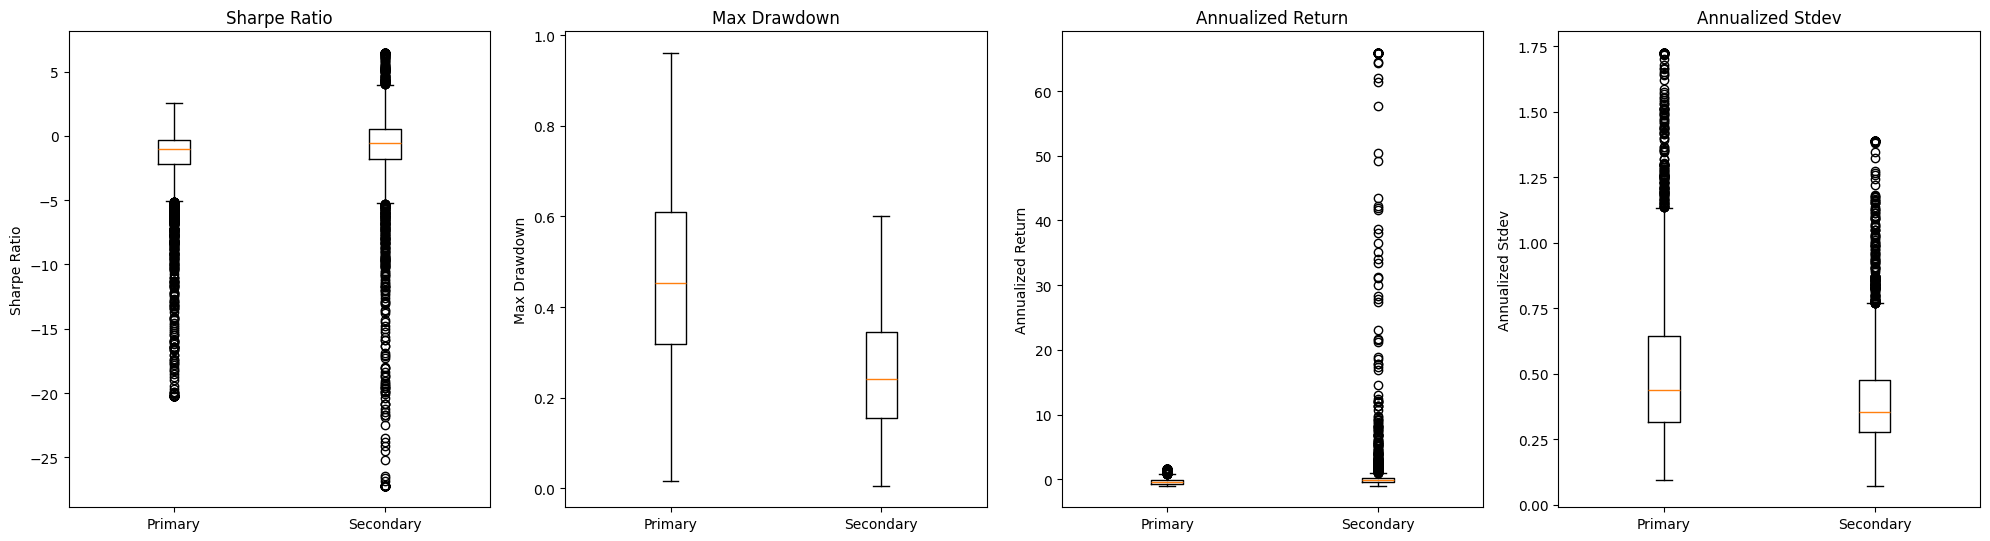

In [353]:


fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.boxplot([metrics_primary[metric], metrics_secondary[metric]], labels=['Primary', 'Secondary'])
    ax.set_title(metric)
    ax.set_ylabel(metric)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [354]:
import graphviz

# Feature names from the model
feature_names = [
    'indret_vw', 'ptb', 'frac_diff_close', 'CrudeOil_Vol', 'bm', 
    'indret_ew', 'NASDAQ_Vol', 'HMA_2', 'z_score', 'NATR_4',
    'from_earnings', 'Gold_Daily_Vol', 'treasury_yield1_vol', 'bb_20_2_bbwidth'
]

# Initialize the graph
g = graphviz.Digraph()

# Add nodes for each feature
for name in feature_names:
    g.node(name, fontsize="10")

# Add additional nodes that are known to influence the features
g.node("Market Trend", style="dashed", fontsize="10")
g.node("Economic Conditions", style="dashed", fontsize="10")
g.node("Interest Rates", style="dashed", fontsize="10")
g.node("Commodity Prices", style="dashed", fontsize="10")
g.node("Volatility", style="dashed", fontsize="10")

# Adding relationships (edges) between features and these broader economic factors
g.edge("Market Trend", "indret_vw")
g.edge("Market Trend", "indret_ew")
g.edge("Market Trend", "HMA_2")
g.edge("Market Trend", "z_score")
g.edge("Market Trend", "frac_diff_close")
g.edge("Economic Conditions", "ptb")
g.edge("Economic Conditions", "bm")
g.edge("Economic Conditions", "NASDAQ_Vol")
g.edge("Interest Rates", "treasury_yield1_vol")
g.edge("Interest Rates", "ptb")
g.edge("Commodity Prices", "Gold_Daily_Vol")
g.edge("Commodity Prices", "CrudeOil_Vol")
g.edge("Volatility", "NATR_4")
g.edge("Volatility", "bb_20_2_bbwidth")

# Connect features based on their causal relationships
g.edge("indret_vw", "HMA_2")
g.edge("indret_ew", "z_score")
g.edge("NASDAQ_Vol", "HMA_2")
g.edge("Gold_Daily_Vol", "NATR_4")
g.edge("treasury_yield1_vol", "frac_diff_close")
g.edge("from_earnings", "ptb")
g.edge("HMA_2", "bb_20_2_bbwidth")

# Include the target (Profitable Trade) and connect features to it
g.node("Profitable Trade", style="filled", fontsize="10")
g.edge("HMA_2", "Profitable Trade")
g.edge("NATR_4", "Profitable Trade")
g.edge("Gold_Daily_Vol", "Profitable Trade")
g.edge("NASDAQ_Vol", "Profitable Trade")
g.edge("treasury_yield1_vol", "Profitable Trade")
g.edge("bb_20_2_bbwidth", "Profitable Trade")
g.edge("indret_vw", "Profitable Trade")
g.edge("ptb", "Profitable Trade")
g.edge("frac_diff_close", "Profitable Trade")
g.edge("bm", "Profitable Trade")
g.edge("indret_ew", "Profitable Trade")
g.edge("z_score", "Profitable Trade")
g.edge("from_earnings", "Profitable Trade")

# Render the graph
g.render("data/causal_flow_diagram", format='png')


'data/causal_flow_diagram.png'

In [355]:
def save_model_sklearn(model_name: str):
    """
    Saves models from sklearn to filesystem.

    Args:
        model (sklearn model): Sklearn model.
        path (string): The path to save the model to.
        model_name (string): The name of the model.
    """
    joblib.dump(trained_clf, f'../data/processed/stockscreener/ml_model/{model_name}.joblib')